In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from tqdm import tqdm
import seaborn as sns
import pickle
sns.set_context('poster')
import glob
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, plot_roc_curve
from scipy.stats import pearsonr, spearmanr
from scipy.stats import wasserstein_distance
import os
import gn4pions.modules.resolution_util as ru
import gn4pions.modules.plot_util as pu
import atlas_mpl_style as ampl
ampl.use_atlas_style(usetex=True)
plt.style.use('print')
ampl.set_color_cycle('Oceanic',10)

In [ ]:
# data_dir = 'results/onetrack_multicluster/full_dataset_20220526_regress' 
# pion_list = ['pion']
# sym_list = ['+-',]
# concat_type = ['False']
# model_name = ['ConcatFalse']
# line = ['-', '--', ':']
# blues = matplotlib.cm.Blues_r(np.linspace(0,1,20))
# oranges = matplotlib.cm.Oranges_r(np.linspace(0,1,20))

# plt.figure(figsize=(15,8))
# hist_files = np.sort(glob.glob(data_dir + 'losses.npz'))
# print('Loading from {}'.format(data_dir))

# # hist = np.load(hist_files[0])
# hist = np.load(data_dir + '/losses.npz')
# # plt.semilogy(hist['training'].mean(axis=1), color=blues[5, :3], 
# #              label=r'Train', linestyle=line[0])
# # plt.semilogy(hist['validation'].mean(axis=1), color=oranges[5, :3], 
# #              label=r'Validation', linestyle=line[0])

# plt.plot(hist['training'].mean(axis=1), color=blues[5, :3], 
#              label=r'Train', linestyle=line[0])
# plt.plot(hist['validation'].mean(axis=1), color=oranges[5, :3], 
#              label=r'Validation', linestyle=line[0])

# # plt.semilogy(hist['training_regress'].mean(axis=1), color=blues[5, :3], 
# #              label=r'Train (Regression)', linestyle=line[1])
# # plt.semilogy(hist['validation_regress'].mean(axis=1), color=oranges[5, :3], 
# #              label=r'Validation (Regression)', linestyle=line[1])

# # plt.semilogy(hist['training_class'].mean(axis=1), color=blues[5, :3], 
# #              label=r'Train (Classification)', linestyle=line[2])
# # plt.semilogy(hist['validation_class'].mean(axis=1), color=oranges[5, :3], 
# #              label=r'Validation (Classification)', linestyle=line[2])


# plt.ylabel(r'$Loss$')
# plt.xlabel(r'$Epochs$')
# # plt.ylim([1e-4, 2])
# # sns.despine()
# plt.legend(loc="upper right", fontsize=18)
# plt.savefig(data_dir+'/training_mse.png', bbox_inches='tight', dpi=300)
# plt.show()

# Classification

### Load data

In [ ]:
### East Bay GNN, clusters only
pred_file = 'pub_note_results/validation_data_predictions_multiJobTraining_wClusterEcut.npz' # better at classification

predictions = np.load(pred_file, allow_pickle=True)
targets_regress = predictions['cluster_ENG_CALIB_TOT']
targets_class = predictions['pion_type']
outputs_regress = predictions['pred_cluster_ENG_CALIB_TOT']
outputs_class = predictions['pred_prob']
energies = predictions['cluster_ENG_CALIB_TOT']
etas = predictions['cluster_Eta']
em_probs = predictions['cluster_EM_PROBABILITY']

df = pd.DataFrame(np.vstack(
    [targets_class, outputs_class, targets_regress, outputs_regress, energies, etas, em_probs]).T, 
        columns = ["targets_class", "outputs_class", 
                  "targets_regress", "outputs_regress", "energy", "eta", "em_prob"])

df.targets_class = df.targets_class.replace('pion',1)
df.targets_class = df.targets_class.replace('pi0',0)
df.targets_regress = df.targets_regress.astype(float)
df.outputs_regress = df.outputs_regress.astype(float)

In [ ]:
### PFN 
pfn = np.load('pub_note_results/PFN_class_preds_1_10_fixed.npz')
df_pfn = pd.DataFrame(np.vstack(
    [pfn['target'], pfn['predictions'], pfn['energy'], pfn['eta']]).T, 
    columns = ["targets_class", "outputs_class", "energy", "eta"])

In [ ]:
### CNN
cnn = np.load('pub_note_results/cnn_classifier.npz')
cnn['arr_0'].shape
df_cnn = pd.DataFrame(cnn['arr_0'], 
    columns = ["targets_class", "outputs_class", "eta", "energy", "true_energy"])

### Make plots

In [ ]:
# acc = []
# for i in np.arange(0, 1, .01):
#     acc.append(accuracy_score(df.targets_class, df.outputs_class>i))
# plt.plot(np.arange(0, 1, .01), acc, color="crimson")
# plt.xlabel('Threshold')
# plt.ylabel('Classification Accuracy')
# plt.grid()
# plt.savefig(data_dir+'/acc_threshold.png', bbox_inches='tight', dpi=300)
# plt.show()
# print('Max Acc: {:.3f} at {:.2f}'.format(100*np.max(acc), np.argmax(acc)*.01))

# acc = accuracy_score(df.targets_class, df.outputs_class>.5)
# prec = precision_score(df.targets_class, df.outputs_class>.5)
# recall = recall_score(df.targets_class, df.outputs_class>.5)
# f1 = f1_score(df.targets_class, df.outputs_class>.5)

# print('Acc:\t{:.3f}\nPrec:\t{:.3f}\nRecall:\t{:.3f}\nF1:\t{:.3f}'.format(acc, prec, recall, f1))

In [ ]:
fpr_em_prob, tpr_em_prob, _ = roc_curve(df[(df.em_prob > 0) & (np.abs(df.eta) < 0.7)].targets_class, 1-df[(df.em_prob > 0) & (np.abs(df.eta) < 0.7)].em_prob)
df_roc = pd.DataFrame(np.vstack([tpr_em_prob,fpr_em_prob]).T, columns=["tpr","fpr"])
print("Rejection @ {:.0f}% efficiency: {:.3f}".format(0.9*100,1/df_roc[df_roc.tpr > 0.9].fpr.iloc[0]))

In [ ]:
fpr_em_prob, tpr_em_prob, _ = roc_curve(df[(df.em_prob > 0)].targets_class, 1-df[(df.em_prob > 0)].em_prob)
df_roc = pd.DataFrame(np.vstack([tpr_em_prob,fpr_em_prob]).T, columns=["tpr","fpr"])
print("Rejection @ {:.0f}% efficiency: {:.3f}".format(0.9*100,1/df_roc[df_roc.tpr > 0.9].fpr.iloc[0]))

In [ ]:
def get_rejection(df, eff=0.9):
    fpr, tpr, _ = roc_curve(df.targets_class, df.outputs_class)
    df_roc = pd.DataFrame(np.vstack([tpr,fpr]).T, columns=["tpr","fpr"])
    print("Rejection @ {:.0f}% efficiency: {:.3f}".format(eff*100,1/df_roc[df_roc.tpr > eff].fpr.iloc[0]))
    
def make_classification_plots(df, data_dir=".", save_label="", plot_label="GNN"): 
#     ### Confusion matrix 
#     cm = confusion_matrix(df.targets_class, df.outputs_class>0.5, normalize='true')
#     disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
#                                   display_labels=['$\\pi^{0}$', '$\\pi^{\pm}$'])
#     disp.plot(values_format='.3f')
#     plt.savefig(data_dir+'/'+save_label+'_cm.png', dpi=300, bbox_inches='tight')
#     plt.show()

#     ### ROC curve
#     plt.figure()
#     fpr, tpr, _ = roc_curve(df.targets_class, df.outputs_class)
#     roc_auc = auc(fpr, tpr)
#     disp = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
#     disp.plot()
# #     plt.plot(fpr, tpr)
# #     plt.plot([-.2, 1.2], [-.2, 1.2], 'k')
#     plt.axis('square')
#     plt.xlim([-.1, 1.1])
#     plt.ylim([-.1, 1.1])
#     plt.grid()
#     plt.savefig(data_dir+'/'+save_label+'_roc_auc.png', dpi=300, bbox_inches='tight')
# #     plt.show()

#     ### Rejection @ 95% efficiency
#     df_roc = pd.DataFrame(np.vstack([tpr,fpr]).T, columns=["tpr","fpr"])
#     print("Rejection @ 95% efficiency:",1/df_roc[df_roc.tpr > 0.95].fpr.iloc[0])
    
#     ### NN scores
#     plt.figure()
#     plt.hist(df[df.targets_class == 0].outputs_class, 50, density=True, histtype='step', linewidth=2, label='$\\pi^{0}$')
#     plt.hist(df[df.targets_class == 1].outputs_class, 50, density=True, histtype='step', linewidth=2, label='$\\pi^{\\pm}$')
#     plt.legend(loc='upper center')
#     plt.legend()
#     plt.xlabel('Classifier Output')
#     plt.yscale('log')
#     plt.savefig(data_dir+'/'+save_label+'_class_dist.png', dpi=300, bbox_inches='tight')
# #     plt.show()
    
    ### Bins of energy
    eta_range = "|$\eta$|$<3$"
    plt.figure()
    fpr, tpr, _ = roc_curve(df.targets_class, df.outputs_class)
    fpr_bin0, tpr_bin0, _ = roc_curve(df[df.energy < 1].targets_class, 
                                      df[df.energy < 1].outputs_class)
    fpr_bin1, tpr_bin1, _ = roc_curve(df[(df.energy > 1) & (df.energy < 10)].targets_class, 
                                      df[(df.energy > 1) & (df.energy < 10)].outputs_class)
    fpr_bin2, tpr_bin2, _ = roc_curve(df[(df.energy > 10) & (df.energy < 50)].targets_class, 
                                      df[(df.energy > 10) & (df.energy < 50)].outputs_class)
    fpr_bin3, tpr_bin3, _ = roc_curve(df[(df.energy > 50) & (df.energy < 500)].targets_class, 
                                      df[(df.energy > 50) & (df.energy < 500)].outputs_class)
    plt.plot(tpr, np.nan_to_num(1/fpr),label = "All energies",)
    plt.plot(tpr_bin3, np.nan_to_num(1/fpr_bin3),label = "50 < Cluster Energy < 50 GeV",linestyle="dashed")
    plt.plot(tpr_bin2, np.nan_to_num(1/fpr_bin2),label = "10 < Cluster Energy < 50 GeV",linestyle="dotted")
    plt.plot(tpr_bin1, np.nan_to_num(1/fpr_bin1),label = "1 < Cluster Energy < 10 GeV",linestyle="dashdot")
    plt.plot(tpr_bin0, np.nan_to_num(1/fpr_bin0),label = "Cluster Energy < 1 GeV")
    plt.xlim(0.5,1)
    plt.yscale('log')
    plt.ylim(0,5000)
    plt.tick_params(labelsize=14)
    ampl.set_xlabel(r"$\pi^{\pm}$ Efficiency");
    ampl.set_ylabel(r"$\pi^0$ Rejection");
    
    ### if GNN
    if save_label == "gnn": 
        plt.legend(loc="lower left", fontsize=11, handlelength=4);
        ampl.plot.draw_atlas_label(0.6,0.95, status='prelim', simulation=True, 
                                   desc=r"GNN Classification of $\pi^{\pm}$ vs. $\pi^0$ "+"\n"+"Single Pion MC, Topo-clusters, "+eta_range)
        
    
    ### if PFN
    elif save_label == "pfn":
        plt.legend(loc="upper right", fontsize=11, handlelength=4);
        ampl.plot.draw_atlas_label(0.05,0.2, status='prelim', simulation=True, 
                               desc=r"DeepSets/PFN Classification of $\pi^{\pm}$ vs. $\pi^0$ "+"\n"+"Single Pion MC, Topo-clusters, "+eta_range)
        
    plt.savefig(data_dir+'/'+save_label+'_energy_bins.png', bbox_inches='tight')
    plt.savefig(data_dir+'/'+save_label+'_energy_bins.pdf', bbox_inches='tight')
    
#     ### Bins of eta
#     plt.figure(dpi=150)
#     fpr, tpr, _ = roc_curve(df.targets_class, df.outputs_class)
#     fpr_bin0, tpr_bin0, _ = roc_curve(df[np.abs(df.eta) < 0.8].targets_class, 
#                                       df[np.abs(df.eta) < 0.8].outputs_class)
#     fpr_bin1, tpr_bin1, _ = roc_curve(df[(np.abs(df.eta) > 0.8) & (np.abs(df.eta) < 1.37)].targets_class, 
#                                       df[(np.abs(df.eta) > 0.8) & (np.abs(df.eta) < 1.37)].outputs_class)
#     fpr_bin2, tpr_bin2, _ = roc_curve(df[(np.abs(df.eta) > 1.37) & (np.abs(df.eta) < 2.5)].targets_class, 
#                                       df[(np.abs(df.eta) > 1.37) & (np.abs(df.eta) < 2.5)].outputs_class)
#     fpr_bin3, tpr_bin3, _ = roc_curve(df[np.abs(df.eta) > 2.5].targets_class, 
#                                       df[np.abs(df.eta) > 2.5].outputs_class)
#     plt.plot(tpr_bin3, np.nan_to_num(1/fpr_bin3),label = plot_label+" ($|\eta|$ > 2.5)",linestyle="dashed")
#     plt.plot(tpr_bin0, np.nan_to_num(1/fpr_bin0),label = plot_label+" ($|\eta|$ < 0.8)",linestyle="dotted")
#     plt.plot(tpr_bin1, np.nan_to_num(1/fpr_bin1),label = plot_label+" (0.8 < $|\eta|$ < 1.37)",)
#     plt.plot(tpr, np.nan_to_num(1/fpr),label = plot_label+" (All $\eta$ values)", linestyle="dashdot")
#     plt.plot(tpr_bin2, np.nan_to_num(1/fpr_bin2),label = plot_label+" (1.37 < $|\eta|$ < 2.5)",)
#     plt.xlim(0.7,1)
#     plt.yscale('log')
#     plt.ylim(0,500)
#     plt.tick_params(labelsize=14)
#     ampl.set_xlabel(r"$\pi^{\pm}$ Efficiency");
#     ampl.set_ylabel(r"$\pi^0$ Rejection");
#     ampl.plot.draw_atlas_label(0.6,0.95, status='int', simulation=True, desc=r"Classification of $\pi^{\pm}$ vs. $\pi^0$")
#     plt.legend(loc="lower left", fontsize=14);
#     plt.savefig(data_dir+'/'+save_label+'_eta_bins.png', bbox_inches='tight')

In [ ]:
get_rejection(df[np.abs(df.eta)<0.7])

In [ ]:
get_rejection(df)

In [ ]:
make_classification_plots(df_pfn, 
                          data_dir="./pub_note_results", 
                          save_label="pfn", 
                          plot_label="DeepSets/PFN")

In [ ]:
make_classification_plots(df, 
                          data_dir="./pub_note_results", 
                          save_label="gnn", 
                          plot_label="GNN")

In [ ]:
def make_class_comparison_plot(df, df_pfn, df_cnn=None, data_dir="."): 
    fpr, tpr, _ = roc_curve(df.targets_class, df.outputs_class)
    fpr_em_prob, tpr_em_prob, _ = roc_curve(df[df.em_prob > 0].targets_class, 1-df[df.em_prob > 0].em_prob)
    fpr_pfn, tpr_pfn, _ = roc_curve(df_pfn.targets_class, df_pfn.outputs_class)
    if df_cnn is not None:
        fpr_cnn, tpr_cnn, _ = roc_curve(df_cnn.targets_class, df_cnn.outputs_class)
        cnn_rejection_ratios = []
   
    gnn_rejection_ratios = []
    pfn_rejection_ratios = []
    for i in tqdm(tpr_em_prob):
        em_prob_rejection = np.nan_to_num(1/np.mean(fpr_em_prob[np.where(tpr_em_prob==i)]))
        gnn_closest_index = tpr[np.argmin(np.abs(tpr-i))]
        gnn_rejection = np.nan_to_num(1/np.mean(fpr[np.where(tpr==gnn_closest_index)]))
        gnn_rejection_ratios.append(gnn_rejection/em_prob_rejection)
        pfn_closest_index = tpr_pfn[np.argmin(np.abs(tpr_pfn-i))]
        pfn_rejection = np.nan_to_num(1/np.mean(fpr_pfn[np.where(tpr_pfn==pfn_closest_index)]))
        pfn_rejection_ratios.append(pfn_rejection/em_prob_rejection)
        if df_cnn is not None:
            cnn_closest_index = tpr_cnn[np.argmin(np.abs(tpr_cnn-i))]
            cnn_rejection = np.nan_to_num(1/np.mean(fpr_cnn[np.where(tpr_cnn==cnn_closest_index)]))
            cnn_rejection_ratios.append(cnn_rejection/em_prob_rejection)
        
    fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=False, gridspec_kw = {'height_ratios':[3, 1]}, 
#                            figsize=(8, 6), 
    #                        constrained_layout=True
                          )
    ax[0].plot(tpr_em_prob, np.nan_to_num(1/fpr_em_prob),linewidth=2, label = r"$\mathcal{P}^{EM}_{clus}$", linestyle="dashed")
    ax[0].plot(tpr_pfn, np.nan_to_num(1/fpr_pfn),linewidth=2, label = "DeepSets/PFN",linestyle="dotted")
    ax[0].plot(tpr, np.nan_to_num(1/fpr),linewidth=2, label = "GNN",)
    if df_cnn is not None:
        ax[0].plot(tpr_cnn, np.nan_to_num(1/fpr_cnn),linewidth=2, label = "CNN",linestyle="dashdot")
    ax[0].set_xlim(0.6,1)
    ax[0].set_yscale('log')
    ax[0].set_ylim(0,1000)
    ampl.set_xlabel(r"$\pi^{\pm}$ Efficiency", fontsize=14);
    ax[0].set_ylabel(r"$\pi^0$ Rejection", fontsize=14);
    if df_cnn is not None: 
        eta_range = "|$\eta$|$<0.7$"
    else:
        eta_range = "|$\eta$|$<3$"
    ax[0].legend(fontsize=14, loc="lower left");
    ax[0].tick_params(labelsize=14)

    ax[1].plot(tpr_em_prob, np.ones(len(tpr_em_prob)), linewidth=2, label = r"$\mathcal{P}^{EM}_{clus}$",linestyle="dashed")
    ax[1].plot(tpr_em_prob, pfn_rejection_ratios, linewidth=2, label = "DeepSets/PFN",linestyle="dotted")
    ax[1].plot(tpr_em_prob, gnn_rejection_ratios,linewidth=2, label = "GNN",)
    if df_cnn is not None:
        ax[1].plot(tpr_em_prob, cnn_rejection_ratios,linewidth=2, label = "CNN",linestyle="dashdot")
    ax[1].set_ylabel(r"Ratio to $\mathcal{P}^{EM}_{clus}$", fontsize=14);
    ax[1].tick_params(labelsize=14)
    ax[1].set_ylim(0,10);
    
    ampl.plot.draw_atlas_label(0.6,0.9,ax=ax[0], status='prelim', simulation=True, 
                               desc=r"Classification of $\pi^{\pm}$ vs. $\pi^0$"+"\n"+"Single Pion MC, Topo-clusters"+"\n"+eta_range)
    if df_cnn is not None:
        save_name = data_dir+'/class_comparison_cnn.png'
        save_name_pdf = data_dir+'/class_comparison_cnn.pdf'
    else:
        save_name = data_dir+'/class_comparison.png'
        save_name_pdf = data_dir+'/class_comparison.pdf'
    plt.savefig(save_name, bbox_inches='tight') # use the "print" style in ampl instead of dpi!!! 
    plt.savefig(save_name_pdf, bbox_inches='tight') # use the "print" style in ampl instead of dpi!!! 

In [ ]:
make_class_comparison_plot(
    df[np.abs(df.eta)<0.7],  # use with df_cnn
    df_pfn[np.abs(df_pfn.eta)<0.7], # use with df_cnn
    df_cnn, 
    data_dir = "./pub_note_results")

In [ ]:
make_class_comparison_plot(df,df_pfn, data_dir = "./pub_note_results")

In [ ]:
rejections = []
energies = np.linspace(df.energy.min(), df.energy.max(), 25)
for energy in tqdm(energies[:-1]):
    fpr, tpr, _ = roc_curve(df[df.energy > energy].targets_class, df[df.energy > energy].outputs_class)
    df_roc = pd.DataFrame(np.vstack([tpr,fpr]).T, columns=["tpr","fpr"])
    rejections.append(1/df_roc[(df_roc.tpr > 0.95)].fpr.iloc[0])

In [ ]:
plt.plot(energies[:-1], rejections, color="dodgerblue")
plt.xlabel("Cluster Energy [GeV]", fontsize=26)
plt.ylabel("Rejection (1/FPR) at 95% Efficiency", fontsize=26)
# plt.savefig(data_dir+'/rej_95_eff_vs_e.png', dpi=300, bbox_inches='tight')

# Regression

In [33]:
### EM & LCW Calibrations
# pred_file = 'results/no_cuts_clusters_and_tracks_hadweight/full_dataset_20220316/predictions.npz' # old
pred_file = 'results/no_cuts_cluster_and_tracks/full_dataset_20220602_regress/predictions.npz' # new
predictions = np.load(pred_file)
print(predictions.files)
targets_regress = predictions['targets'][:, 0]
outputs_regress = predictions['outputs'][:, 0]
energies = predictions['energies']
etas = predictions['etas']
em_probs = predictions['em_probs']
cluster_calib_e = predictions['cluster_calib_es']
cluster_had_weight = predictions['cluster_had_weights']
# truth_particle_e = 10**predictions['truth_particle_es']

df_em_lcw = pd.DataFrame(np.vstack(
    [
        targets_regress, outputs_regress, 
        energies, 
        etas, 
        em_probs, 
        cluster_calib_e, 
        cluster_had_weight, 
#         truth_particle_e, 
    ]).T, columns = [
                     "targets_regress", "outputs_regress", 
                     "energy", "eta", 
                    "em_prob", "cluster_calib_e", 
                 "cluster_had_weight", 
#     "truth_particle_e",
                           ])

['targets', 'outputs', 'energies', 'etas', 'em_probs', 'cluster_calib_es', 'cluster_had_weights', 'truth_particle_es', 'truth_particle_pts', 'track_pts', 'track_etas']


In [36]:
files = glob.glob("../data/no_cuts_clusters_and_tracks_march2022/pion_files/*.npy")[400:]
df_old = pd.concat([pd.DataFrame(np.load(file, allow_pickle=True).item()) for file in tqdm(files)])
max_n_clusters = pd.DataFrame(pd.DataFrame(df_old.cluster_E.to_list())).shape[1]
df_cluster_calib_e = pd.DataFrame(pd.DataFrame(df_old.cluster_E_LCCalib.to_list(), columns=['col_'+str(x) for x in np.arange(max_n_clusters)]))
df_cluster_e = pd.DataFrame(pd.DataFrame(df_old.cluster_E.to_list(), columns=['col_'+str(x) for x in np.arange(max_n_clusters)]))
df_had_weight = pd.DataFrame(pd.DataFrame(df_old.cluster_HAD_WEIGHT.to_list(), columns=['col_'+str(x) for x in np.arange(max_n_clusters)]))
# df_old["track_pt"] = df_old.trackPt.explode().astype(np.float32)

tracks = []
for row in df_old.index:
    if len(df_old['trackPt'].iloc[row]) == 1:
        tracks.append(df_old['trackPt'].iloc[row][0])
    else:
        tracks.append(0)

df_old['track_pt'] = tracks
# df_old = df_old[df_old.track_pt < 5000]

df_cluster_e.replace([np.inf, -np.inf], np.nan, inplace=True)
df_had_weight.replace([np.inf, -np.inf], np.nan, inplace=True)

df_cluster_e = df_cluster_e.fillna(0)
df_had_weight = df_had_weight.fillna(0)

df_cluster_e = df_cluster_e.astype('float32')
df_had_weight = df_had_weight.astype('float32')

df_lcw = df_cluster_e.multiply(df_had_weight)

df_old['cluster_e_0'] = df_cluster_e['col_0']
df_old['cluster_calib_e_0'] = df_cluster_calib_e['col_0']
# df_old = df_old[df_old.cluster_e_0 > 0.5]
df_old['lcw_0'] = df_lcw['col_0']
df_old['sum_cluster_e'] = np.sum(df_cluster_e, axis=1)
df_old['sum_lcw'] = np.sum(df_lcw, axis=1)
df_old['truth_particle_e'] = df_old.truthPartE.explode()
vars = ['cluster_e_0','sum_cluster_e','lcw_0','sum_lcw','truth_particle_e']
df_old[vars] = df_old[vars].astype('float32')

100%|██████████| 100/100 [02:54<00:00,  1.75s/it]


In [35]:
files = glob.glob("../data/no_cuts_cluster_and_tracks/pion_files/*.npy")[400:]
df_new = pd.concat([pd.DataFrame(np.load(file, allow_pickle=True).item()) for file in tqdm(files)])
max_n_clusters = pd.DataFrame(pd.DataFrame(df_new.cluster_E.to_list())).shape[1]
df_cluster_calib_e = pd.DataFrame(pd.DataFrame(df_new.cluster_E_LCCalib.to_list(), columns=['col_'+str(x) for x in np.arange(max_n_clusters)]))
df_cluster_e = pd.DataFrame(pd.DataFrame(df_new.cluster_E.to_list(), columns=['col_'+str(x) for x in np.arange(max_n_clusters)]))
df_had_weight = pd.DataFrame(pd.DataFrame(df_new.cluster_HAD_WEIGHT.to_list(), columns=['col_'+str(x) for x in np.arange(max_n_clusters)]))
# df_new["track_pt"] = df_new.trackPt.explode().astype(np.float32)

tracks = []
for row in df_new.index:
    if len(df_new['trackPt'].iloc[row]) == 1:
        tracks.append(df_new['trackPt'].iloc[row][0])
    else:
        tracks.append(0)

df_new['track_pt'] = tracks
# df_new = df_new[df_new.track_pt < 5000]

df_cluster_e.replace([np.inf, -np.inf], np.nan, inplace=True)
df_had_weight.replace([np.inf, -np.inf], np.nan, inplace=True)

df_cluster_e = df_cluster_e.fillna(0)
df_had_weight = df_had_weight.fillna(0)

df_cluster_e = df_cluster_e.astype('float32')
df_had_weight = df_had_weight.astype('float32')

df_lcw = df_cluster_e.multiply(df_had_weight)

df_new['cluster_e_0'] = df_cluster_e['col_0']
df_new['cluster_calib_e_0'] = df_cluster_calib_e['col_0']
# df_new = df_new[df_new.cluster_e_0 > 0.5]
df_new['lcw_0'] = df_lcw['col_0']
df_new['sum_cluster_e'] = np.sum(df_cluster_e, axis=1)
df_new['sum_lcw'] = np.sum(df_lcw, axis=1)
df_new['truth_particle_e'] = df_new.truthPartE.explode()
vars = ['cluster_e_0','sum_cluster_e','lcw_0','sum_lcw','truth_particle_e']
df_new[vars] = df_new[vars].astype('float32')

100%|██████████| 100/100 [03:05<00:00,  1.85s/it]


In [57]:
df_old.keys()

Index(['cluster_cell_E', 'cluster_cell_ID', 'trackPt', 'trackD0', 'trackZ0',
       'trackEta_EMB2', 'trackPhi_EMB2', 'trackEta', 'trackPhi', 'nCluster',
       'nTrack', 'truthPartE', 'cluster_ENG_CALIB_TOT', 'cluster_E',
       'cluster_Eta', 'cluster_Phi', 'cluster_EM_PROBABILITY',
       'cluster_E_LCCalib', 'cluster_HAD_WEIGHT', 'track_pt', 'cluster_e_0',
       'cluster_calib_e_0', 'lcw_0', 'sum_cluster_e', 'sum_lcw',
       'truth_particle_e'],
      dtype='object')

In [61]:
[key for key in df_new.keys() if key not in df_old.keys()]

['trackEta_EME2', 'trackPhi_EME2', 'truthPartPt']

In [ ]:
plt.hist(np.array(df_1.cluster_e_0), histtype="step", label="Numpy Files");
plt.hist(df_2.cluster_e_0, histtype="step", label="Preprocessed");
plt.legend();

In [ ]:
df_em_lcw[['cluster_e_0','lcw_0','cluster_calib_e_0']]

In [ ]:
df_em_lcw_2[['energy','cluster_calib_e']]

In [ ]:

# df_lcw = pd.DataFrame(pd.DataFrame(df_em_lcw.cluster_HAD_WEIGHT.to_list())*df_cluster_e
# df_em_lcw["sum_lcw"] = np.sum(pd.DataFrame(pd.DataFrame(df_em_lcw.cluster_E.to_list()))*pd.DataFrame(pd.DataFrame(df_em_lcw.cluster_HAD_WEIGHT.to_list())), axis=1)
# df_em_lcw[['truthPartE','cluster_e_0','lcw_0','sum_cluster_e','sum_lcw']] = df_em_lcw[['truthPartE','cluster_e_0','lcw_0','sum_cluster_e','sum_lcw']].astype('float32')
# df_em_lcw[['truthPartE','cluster_e_0','lcw_0','sum_cluster_e','sum_lcw']].replace([np.inf, -np.inf], np.nan, inplace=True)
# df_em_lcw[['truthPartE','cluster_e_0','lcw_0','sum_cluster_e','sum_lcw']] = df_em_lcw[['truthPartE','cluster_e_0','lcw_0','sum_cluster_e','sum_lcw']].fillna(0)
# df_em_lcw[['truthPartE','cluster_e_0','lcw_0','sum_cluster_e','sum_lcw']] = df_em_lcw[['truthPartE','cluster_e_0','lcw_0','sum_cluster_e','sum_lcw']].astype('float32')


In [ ]:
### East Bay GNN w/ clusters only 
pred_file = 'pub_note_results/validation_data_predictions_multiJobTraining.npz' # better at regression

predictions = np.load(pred_file, allow_pickle=True)
targets_regress = predictions['cluster_ENG_CALIB_TOT']
targets_class = predictions['pion_type']
outputs_regress = predictions['pred_cluster_ENG_CALIB_TOT']
outputs_class = predictions['pred_prob']
energies = predictions['cluster_ENG_CALIB_TOT']
etas = predictions['cluster_Eta']
em_probs = predictions['cluster_EM_PROBABILITY']

df = pd.DataFrame(np.vstack(
    [targets_class, outputs_class, targets_regress, outputs_regress, energies, etas, em_probs]).T, 
        columns = ["targets_class", "outputs_class", 
                  "targets_regress", "outputs_regress", "energy", "eta", "em_prob"])

df.targets_class = df.targets_class.replace('pion',1)
df.targets_class = df.targets_class.replace('pi0',0)
df.targets_regress = df.targets_regress.astype(float)
df.outputs_regress = df.outputs_regress.astype(float)

In [62]:
### East Bay GNN w/ tracks 
data_dir = 'results/onetrack_multicluster/full_dataset_20220601_regress/'
# pred_file = 'results/onetrack_multicluster/full_dataset_20220314/predictions.npz' # full training 1 
# pred_file = 'results/onetrack_multicluster_hadweight/full_dataset_20220314/predictions.npz' # full training 2 
# pred_file = 'results/onetrack_multicluster/full_dataset_20220408_regress/predictions.npz' # post-bugfix, w/ track pt
pred_file = data_dir+'/predictions.npz'
# pred_file = data_dir+'/predictions.npz' # post-bugfix, w/ track pt
predictions = np.load(pred_file)
print(predictions.files)
targets_regress = predictions['targets'][:, 0]
# targets_class = predictions['targets'][:, 1]
outputs_regress = predictions['outputs'][:, 0]
# outputs_class = predictions['outputs'][:, 1]
energies = predictions['energies']
etas = predictions['etas']
em_probs = predictions['em_probs']
truth_particle_es = 10**predictions['truth_particle_es']
truth_particle_pts = predictions['truth_particle_pts']
track_pts = predictions['track_pts']
track_etas = predictions['track_etas']
cluster_calib_e = predictions['cluster_calib_es']
cluster_had_weight = predictions['cluster_had_weights']

df = pd.DataFrame(np.vstack(
    [
#         targets_class, 
#         outputs_class, 
     targets_regress, outputs_regress, 
        energies, etas, em_probs,
     truth_particle_es,
     truth_particle_pts, 
        track_pts,
        track_etas,
        cluster_calib_e, 
        cluster_had_weight,
    ]).T, 
                 columns = [
#                      "targets_class", 
#                      "outputs_class", 
                     "targets_regress", 
                     "outputs_regress", 
                     "energy", "eta", "em_prob", 
                     "truth_particle_e",
                     "truth_particle_pt", 
                     "track_pt", "track_eta",
                     "cluster_calib_e",  "cluster_had_weight",
                           ])

['targets', 'outputs', 'energies', 'etas', 'em_probs', 'cluster_calib_es', 'cluster_had_weights', 'truth_particle_es', 'truth_particle_pts', 'track_pts', 'track_etas']


In [ ]:
df[["targets_regress","outputs_regress"]] # note that these are scaled! 

In [ ]:
### DeepSets with tracks
# russell_old = np.load('pub_note_results/target_preds_PFN_base_STMC_--LR_1e-03--BS_2600--EP_800--EV_200000--2022-03-04.npz')
# df_russell_old = pd.DataFrame(np.vstack(
#     [np.e**russell_old['args'][0,:], np.e**russell_old['args'][1,:]]).T, 
#     columns = ["targets_regress", "outputs_regress"])


# russell = np.load('pub_note_results/target_preds_PFN_base_STMC--LR_1e-03--BS_1800--EP_1000--EV_200000--2022-03-24.npz')
# df_russell = pd.DataFrame(np.vstack(
#     [russell['args'][0,:], russell['args'][1,:], russell['args'][2,:]]).T, 
#     columns = ["targets_regress", "outputs_regress", "eta"])

# tnet_old = np.load('pub_note_results/target_preds_PFN_wTNet_STMC_--LR_1e-03--BS_2000--EP_800--EV_200000--2022-03-05.npz')
# df_tnet_old = pd.DataFrame(np.vstack(
#     [np.e**tnet_old['args'][0,:], np.e**tnet_old['args'][1,:]]).T, 
#     columns = ["targets_regress", "outputs_regress"])

# tnet = np.load('pub_note_results/target_preds_PFN_wTNet_STMC--LR_1e-03--BS_1800--EP_800--EV_200000--2022-03-11.npz')
# df_tnet = pd.DataFrame(np.vstack(
#     [tnet['args'][0,:], tnet['args'][1,:], tnet['args'][2,:]]).T, 
#     columns = ["targets_regress", "outputs_regress", "eta"])

### Cluster-only
russell_clusteronly = np.load('pub_note_results/target_preds_PFN_base_STMCv2--LR_1e-03--BS_1600--EP_200--EV_200000--2022-04-29_CLO.npz')
clusteronly_mean = np.loadtxt('pub_note_results/CLO_50_files_Y_logmean.txt')
df_russell_clusteronly = pd.DataFrame(np.vstack([np.e**(russell_clusteronly['args'][0,:]+clusteronly_mean), 
                       np.e**(russell_clusteronly['args'][1,:]+clusteronly_mean), 
                       russell_clusteronly['args'][2,:]]).T, 
             columns = ["targets_regress", "outputs_regress", "eta"])
df_russell_clusteronly["truth_particle_e"] = df_russell_clusteronly["targets_regress"]

### Single-track, multi-cluster
russell_new = np.load('pub_note_results/target_preds_PFN_base_STMCv2--LR_1e-03--BS_1600--EP_200--EV_200000--2022-04-22.npz')
stmc_mean = np.loadtxt('pub_note_results/STMC_v2_25_files_Y_logmean.txt')
df_russell_new = pd.DataFrame(np.vstack([np.e**(russell_new['args'][0,:]+stmc_mean), 
                       np.e**(russell_new['args'][1,:]+stmc_mean), 
                       russell_new['args'][2,:]]).T, 
             columns = ["targets_regress", "outputs_regress", "eta"])
df_russell_new["truth_particle_e"] = df_russell_new["targets_regress"]

In [ ]:
### Sanmay
edgeconv = np.load('pub_note_results/EdgeConv_Prediction_TRK_2.npz')
df_edgeconv = pd.DataFrame(np.vstack([edgeconv['target'],edgeconv['prediction']]).T, columns=["targets_regress", "outputs_regress"])
transformer = np.load('pub_note_results/Attention_Prediction_TRK_2.npz')
df_transformer = pd.DataFrame(np.vstack([transformer['target'],transformer['prediction']]).T, columns=["targets_regress", "outputs_regress"])

In [22]:
def make_response_plot(y_true, y_pred, y_ratio, pion_label, f_name=''):
#     y_ratio = y_pred/y_true

    p_r = pearsonr(y_true,y_pred)[0]
    s_r = spearmanr(y_true,y_pred)[0]
    mse = mean_squared_error(y_true,y_pred)
    mae = mean_absolute_error(y_true,y_pred)
    r2 = r2_score(y_true,y_pred)
    print("r2:{:.3f}".format(r2))
    print("PearsonR:{:.3f}, SpearmanR:{:.3f}, MSE:{:.3f}, MAE:{:.3f}".
          format(p_r, s_r, mse, mae))
    xcenter, medRegCNN = ru.responsePlot(y_true, y_ratio,
                                         figfile = f_name,
                                         statistic = 'median',
                                         atlas_x = 0.55, atlas_y = 0.95, simulation = True,
                                         textlist = [{'x': 0.55, 'y': 0.85, 'text': pion_label}])
    return xcenter, medRegCNN

def make_hist_plot(y_true, y_pred, pion_label, f_name=None):
    print('Wasserstein distance: {:.3f}'.format(wasserstein_distance(y_true, y_pred)))
    fig = plt.figure(figsize=(20,10))
    plt.hist(y_true, bins=np.linspace(-1., 4., 100), alpha=.5, label=r'$True$')
    plt.hist(y_pred, bins=np.linspace(-1., 4., 100), alpha=.5, label=r'$Predicted$')
    plt.legend(loc='upper right')
    plt.xlabel(r'$Log\ values$')
    plt.ylabel(r'$Counts$')
    plt.xlim([-1.5, 4.])

    atlas_x = 0.55 
    atlas_y = 0.95 
    simulation = True
    textlist = [{'x': 0.55, 'y': 0.88, 'text': pion_label},
                {'x': 0.55, 'y': 0.83, 'text': 'Wasserstein distance: {:.4f}'.format(wasserstein_distance(y_true, y_pred))}]

    pu.drawLabels(fig, atlas_x, atlas_y, simulation, textlist)
    # sns.despine()
    if f_name:
        plt.savefig(f_name)
    plt.show()
    
def make_regression_plots(df, label="", data_dir=".", charged_pions_only=False):
    c_map = sns.color_palette("viridis")

    if charged_pions_only:
        pion_list = ['$\pi^{\pm}$']
        sym_list = ['+-']
        labels = [r'$\pi^{\pm}$']
    else: 
        pion_list = ['$\pi^{all}$', '$\pi^{0}$', '$\pi^{\pm}$']
        sym_list = ['', '0', '+-']
        labels = [r'$\pi^{all}$', r'$\pi^{0}$', r'$\pi^{\pm}$']
        
    blues = matplotlib.cm.viridis(np.linspace(0,1,20))
    oranges = matplotlib.cm.viridis(np.linspace(0,1,20))

    response_median = []

    print('\nPlotting {}'.format(pion_list[0]))
    y_true = df.truth_particle_e # df.targets_regress
    y_pred = df.outputs_regress
    y_ratio = df.outputs_regress/df.targets_regress
    xcenter, medRegCNN = make_response_plot(y_true, y_pred, y_ratio, pion_list[0], 
                                            f_name=data_dir+'/regress_'+label+'_all.png')
    response_median.append(medRegCNN)
    
    if not charged_pions_only:
        if "targets_class" in df.keys():
            print('\nPlotting {}'.format(pion_list[1]))
            y_true = df.targets_regress[df.targets_class==0]
            y_pred = df.outputs_regress[df.targets_class==0]
            xcenter, medRegCNN = make_response_plot(y_true, y_pred, pion_list[1],
                                                   f_name=data_dir+'/regress_'+label+'_pi0.png')
            response_median.append(medRegCNN)

            print('\nPlotting {}'.format(pion_list[2]))
            y_true = df.targets_regress[df.targets_class==1]
            y_pred = df.outputs_regress[df.targets_class==1]
            xcenter, medRegCNN = make_response_plot(y_true, y_pred, pion_list[2],
                                                   f_name=data_dir+'/regress_'+label+'_pion.png')
            response_median.append(medRegCNN)

    np.savez(data_dir+'/response_medians_'+label+'.npz', response_median=response_median, xcenter=xcenter)
    
    ### Response medians 
    pu.lineOverlay(xcenter=xcenter, lines=response_median,  # [iqrOverMedpi0, iqrOverMedpiplus, iqrOverMedpiminus],
                labels = labels,
                xlabel = 'Truth Particle Energy [GeV]', ylabel = 'Response Median',
                figfile = data_dir+'/regress_'+label+'_response_medians.png',
                y_max=1.2, y_min=.9, 
                   x_min = .3, 
                   colorgrouping=0,
                extra_lines= [[[0, 10e3], [1, 1]]],
                linestyles = ['solid', 'solid', 'solid'],
                atlas_x = 0.05, atlas_y = 0.85, simulation = True,
                textlist = [{'x': 0.05, 'y': 0.775, 'text': 'Single $pions$'},
                            {'x': 0.05, 'y': 0.725,  'text': 'Regression Comparison'}])

    ### IQR Plots
    iqr = []
    print('\nPlotting {}'.format(pion_list[0]))
    y_true = df.truth_particle_e #df.targets_regress
    y_ratio = df.outputs_regress/df.targets_regress
    xcenter, iqr_curr= ru.resolutionPlot(y_true, y_ratio, statistic='iqrOverMed')
    iqr.append(iqr_curr)
    
    if not charged_pions_only:
        if "targets_class" in df.keys():
            print('\nPlotting {}'.format(pion_list[1]))
            y_true = df.targets_regress[df.targets_class==0]
            y_pred = df.outputs_regress[df.targets_class==0]
            y_ratio = y_pred/y_true
            xcenter, iqr_curr= ru.resolutionPlot(y_true, y_ratio, statistic='iqrOverMed')
            iqr.append(iqr_curr)

            print('\nPlotting {}'.format(pion_list[2]))
            y_true = df.targets_regress[df.targets_class==1]
            y_pred = df.outputs_regress[df.targets_class==1]
            y_ratio = y_pred/y_true
            xcenter, iqr_curr= ru.resolutionPlot(y_true, y_ratio, statistic='iqrOverMed')
            iqr.append(iqr_curr)
        
    np.savez(data_dir+'/iqr_'+label+'.npz', iqr=iqr, xcenter=xcenter)
    pu.lineOverlay(xcenter=xcenter, lines = iqr,  
                labels = labels,
                xlabel = 'Truth Particle Energy [GeV]', ylabel = 'Response IQR / 2 x Median',
                y_max = 0.5,  # default = 0.5
                   x_min = .3,
                linestyles = [
                    'solid', 
                    'solid', 
                    'solid'
                ],  
                atlas_x = 0.5, atlas_y = 0.675, simulation = True,
                textlist = [{'x': 0.5, 'y': 0.575, 'text': 'Single $pions$'},
                            {'x': 0.5, 'y': 0.525,  'text': 'Regression Comparison'}],
                  figfile=data_dir+'/regress_'+label+'_iqr.png')

Make a set of regression plots on-the-fly:

In [ ]:
make_regression_plots(df, 
                      charged_pions_only = True,
                      label="gnn", 
                      data_dir=data_dir,
#                       data_dir='./pub_note_results',
                     )

# Recreate existing plots:

#### EM & LCW:


Plotting $\pi^{\pm}$
r2:-1.142
PearsonR:0.501, SpearmanR:0.291, MSE:130000.762, MAE:188.431
Saving figure to pub_note_results/regress_em_all.png


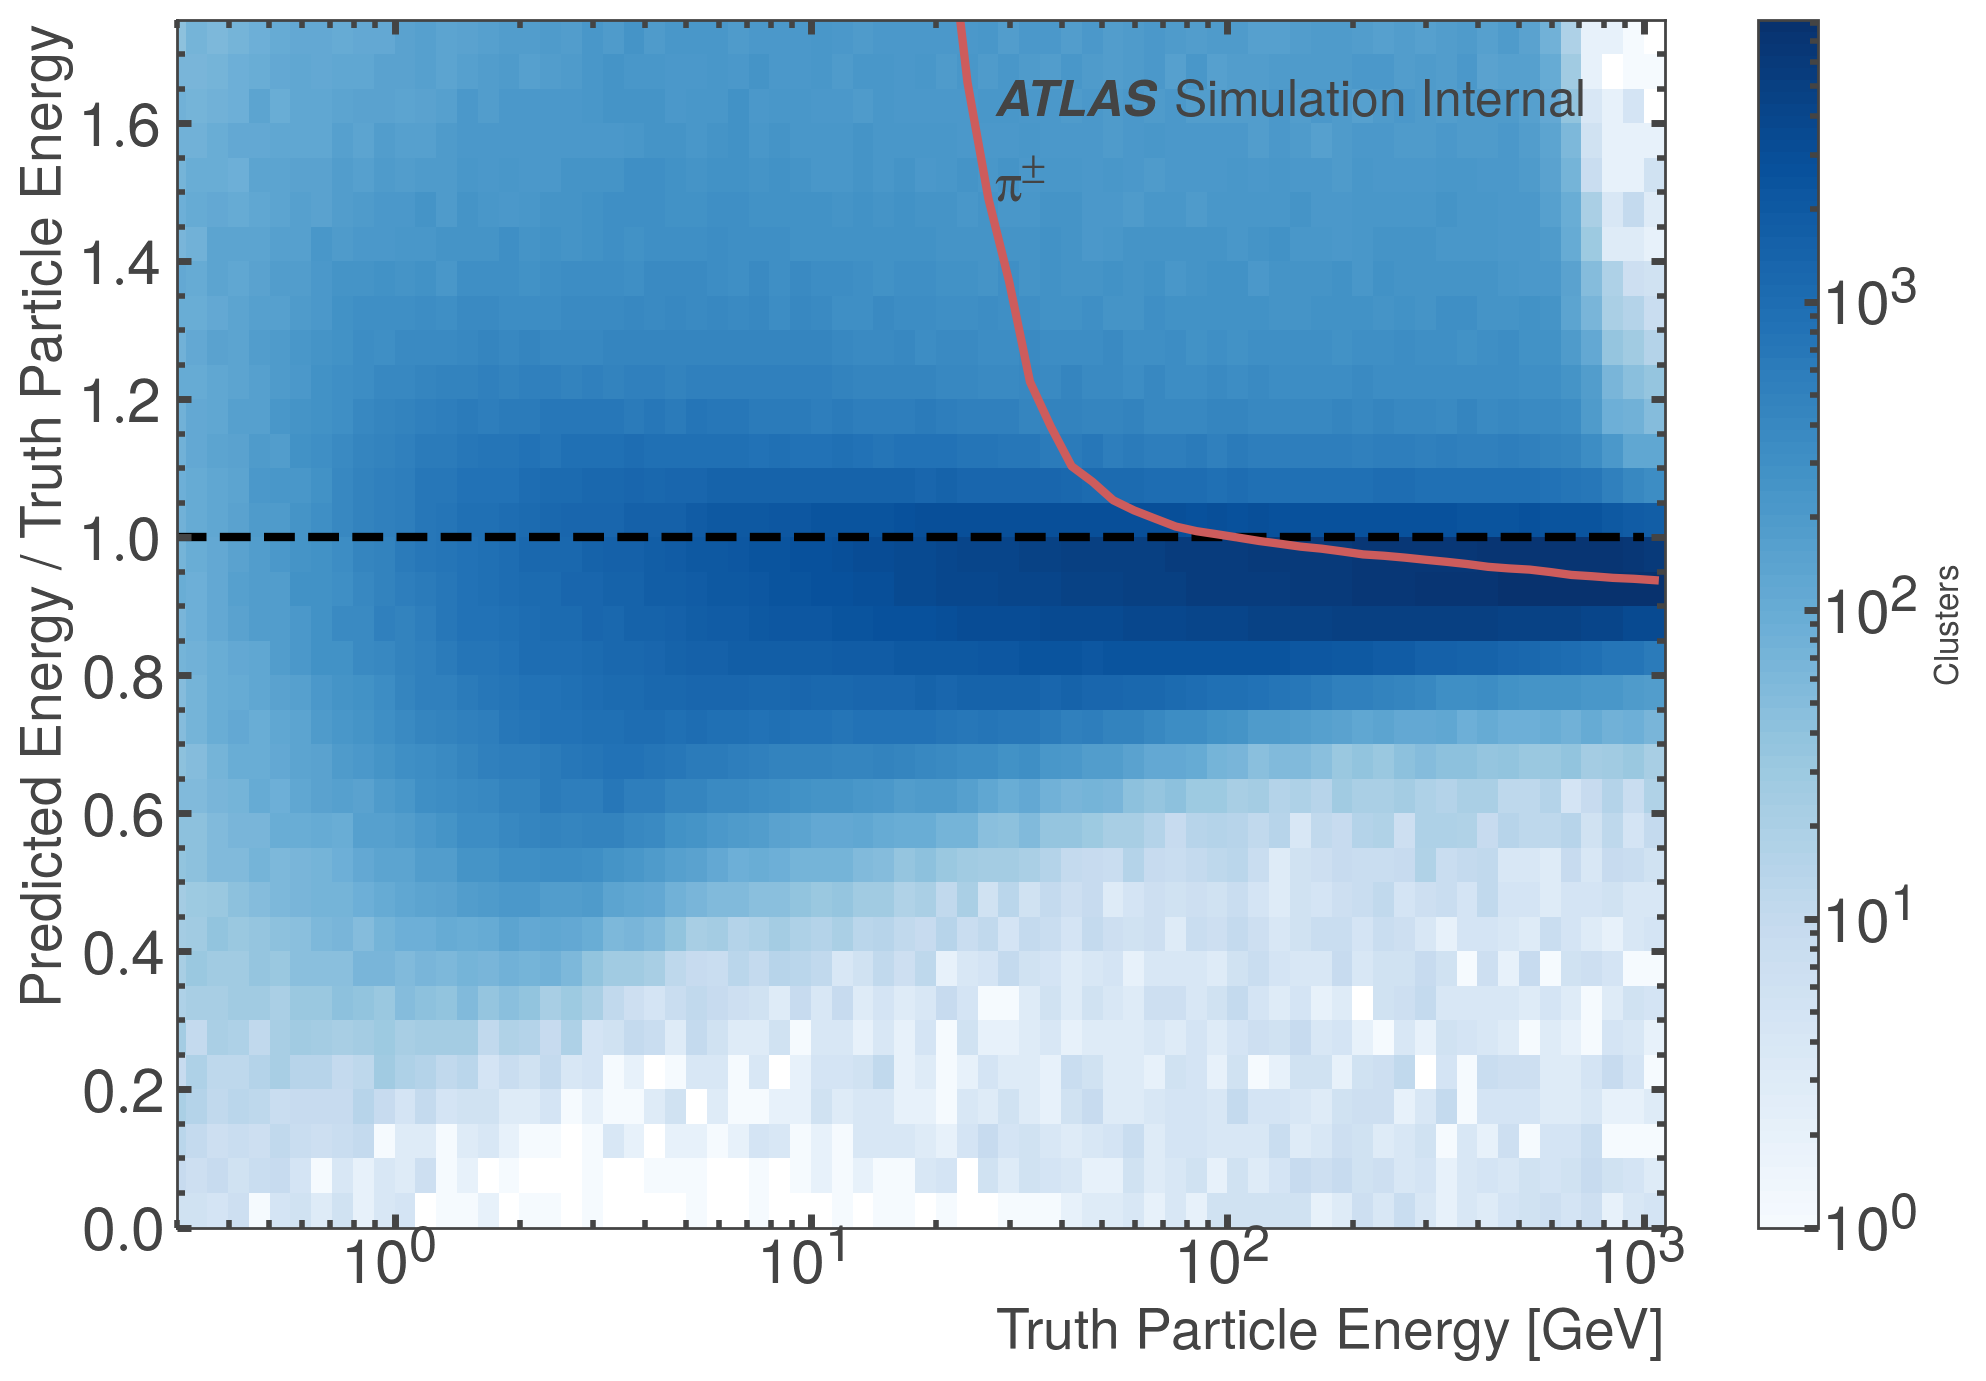


Plotting $\pi^{\pm}$


<Figure size 1600x1200 with 0 Axes>

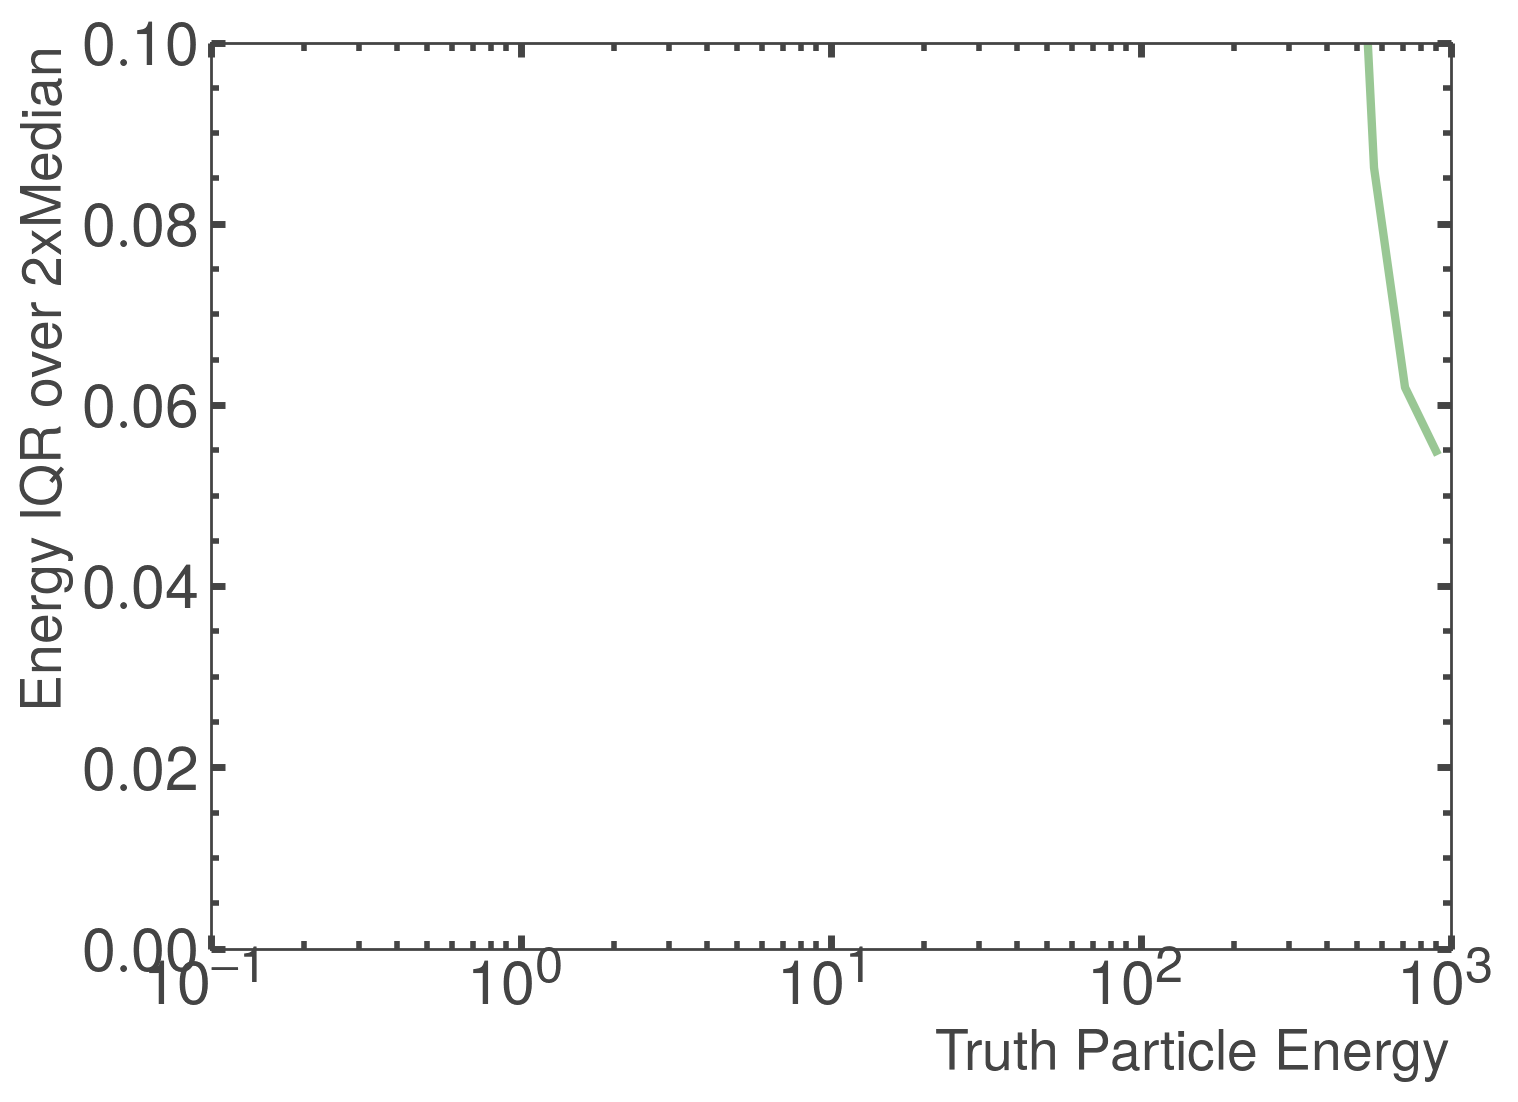

<Figure size 1600x1200 with 0 Axes>

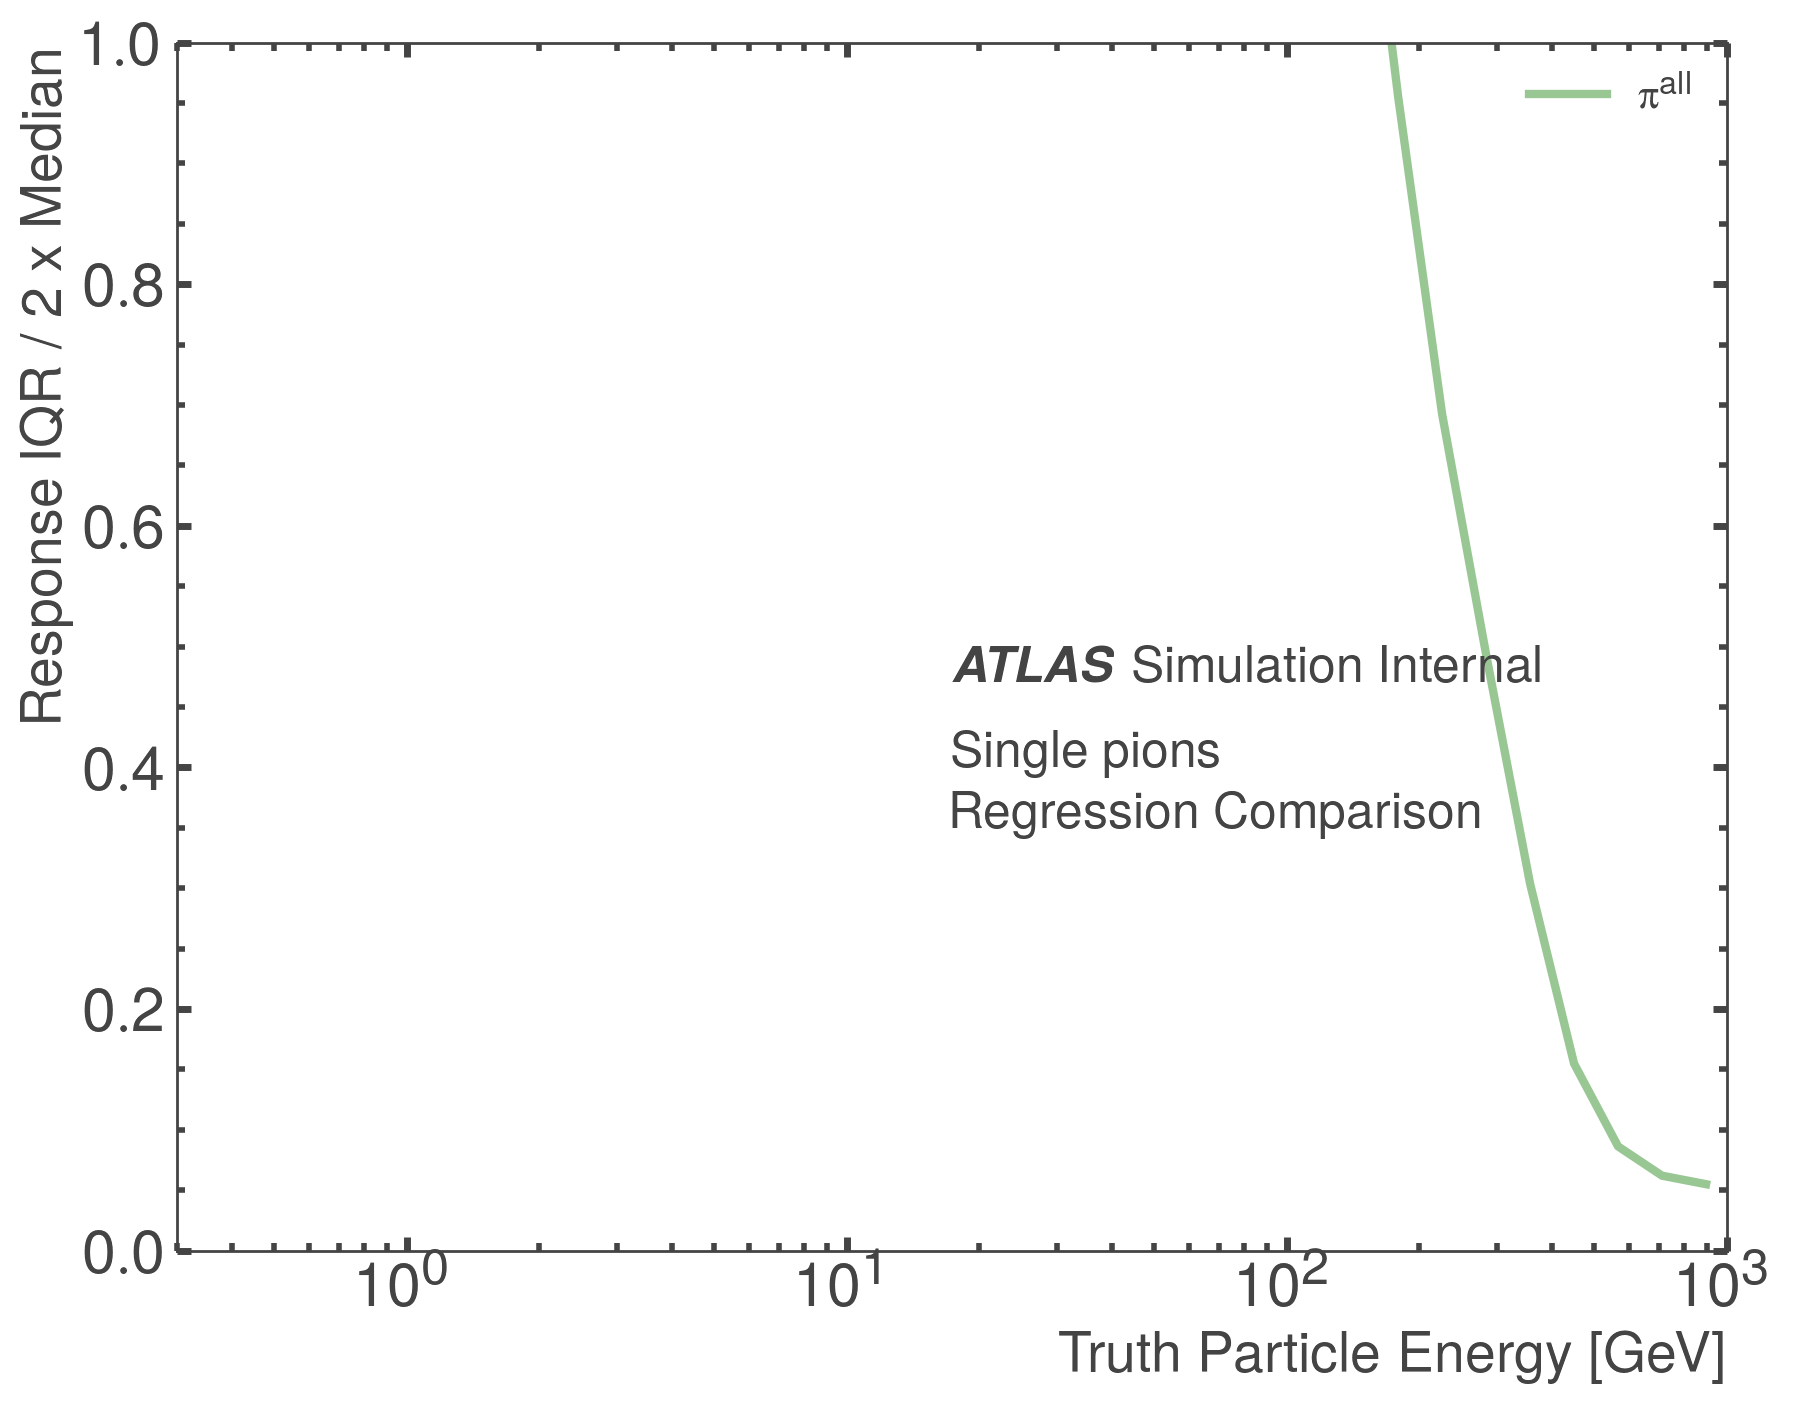


Plotting $\pi^{\pm}$
r2:-1.663
PearsonR:0.485, SpearmanR:0.300, MSE:161608.174, MAE:205.797
Saving figure to pub_note_results/regress_lcw_all.png


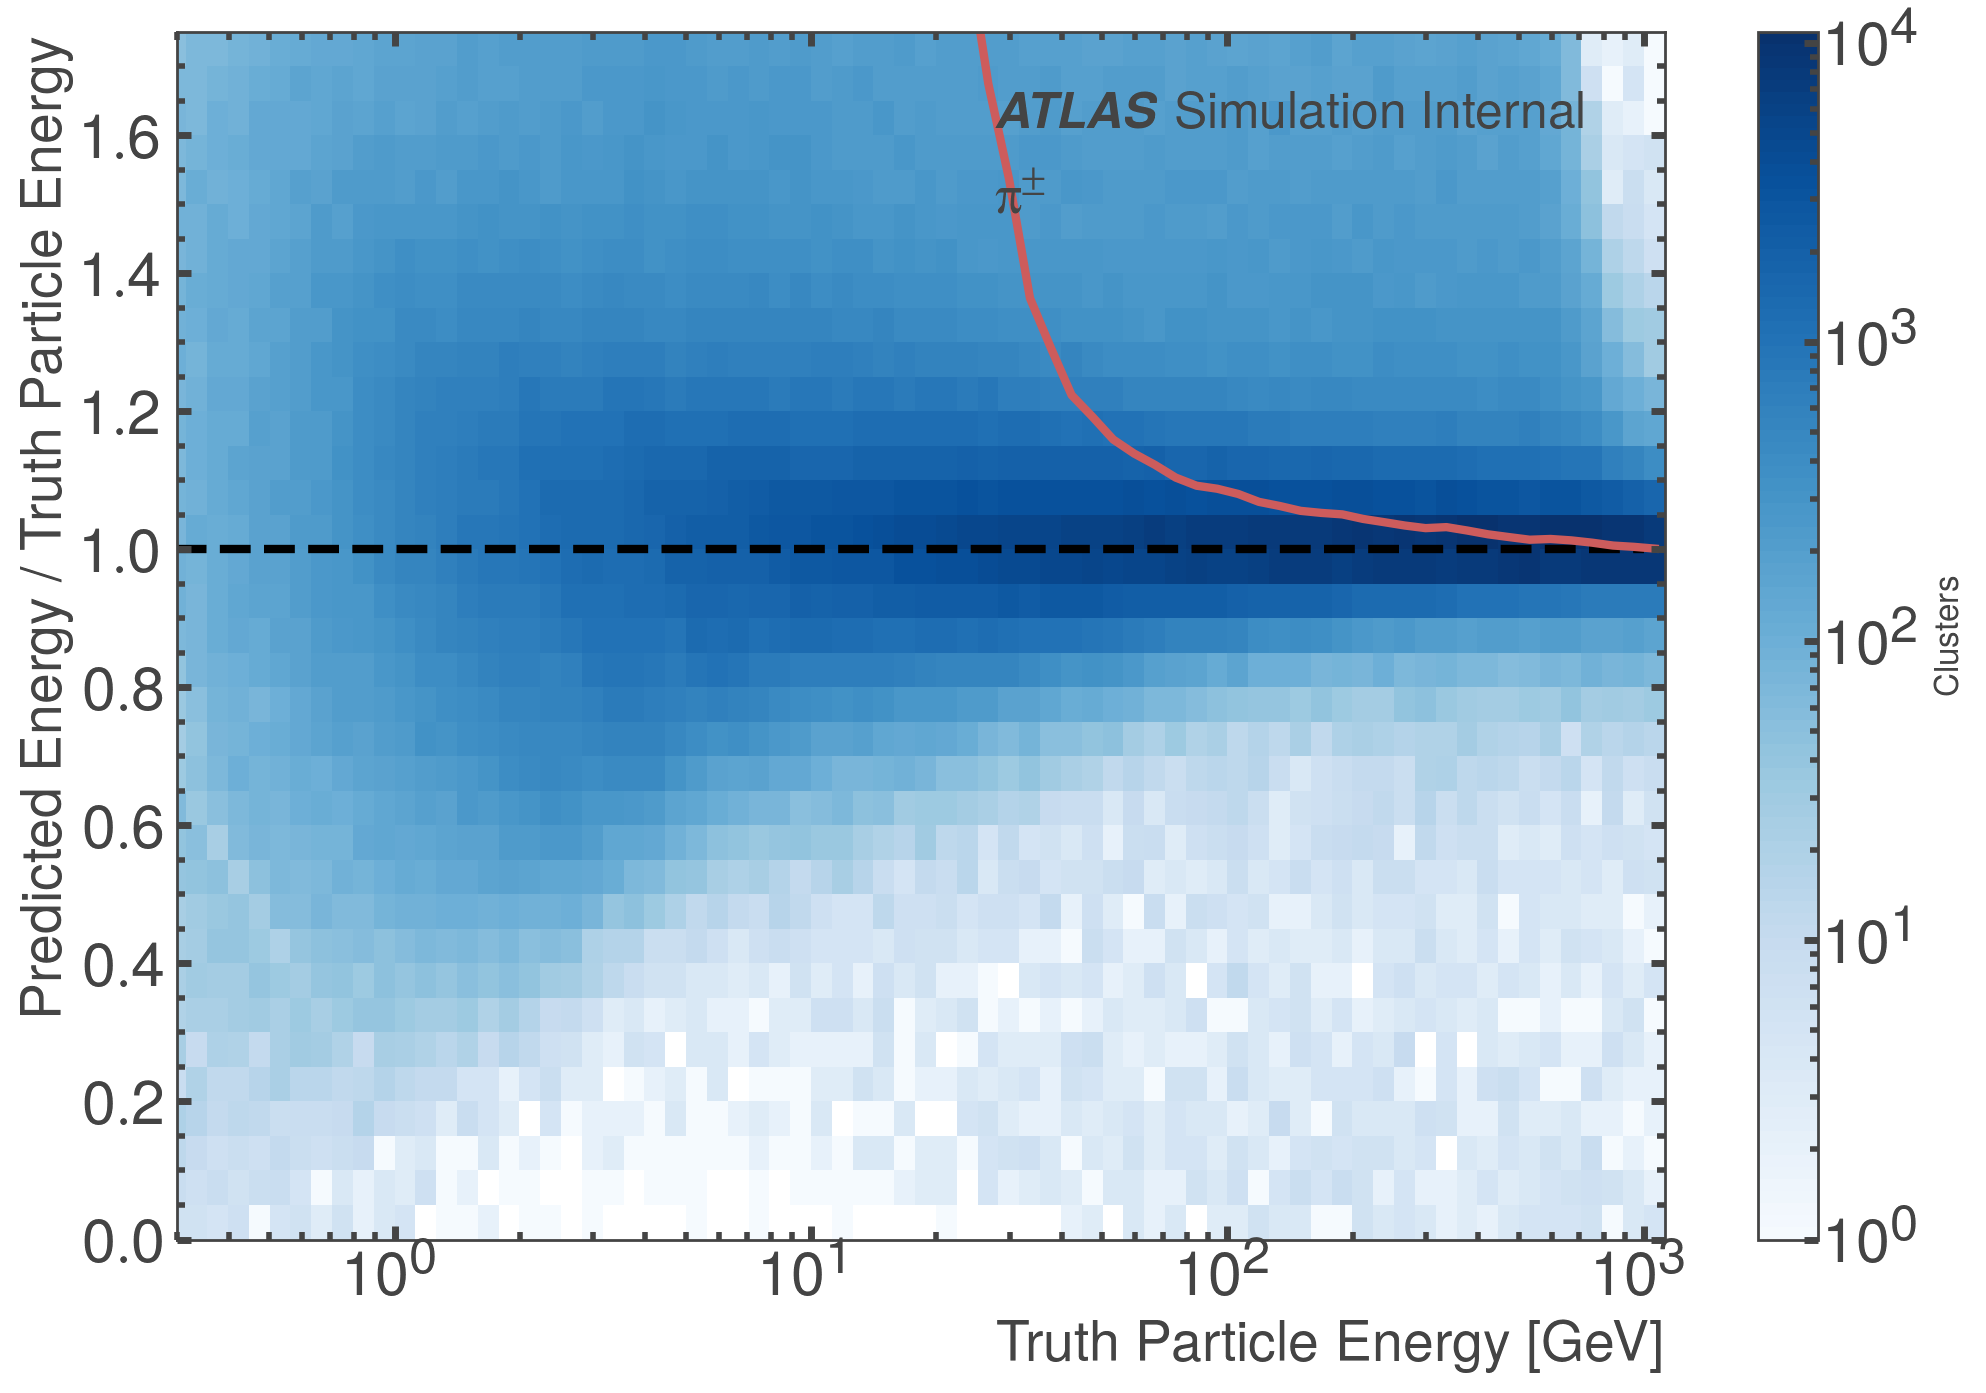


Plotting $\pi^{\pm}$


<Figure size 1600x1200 with 0 Axes>

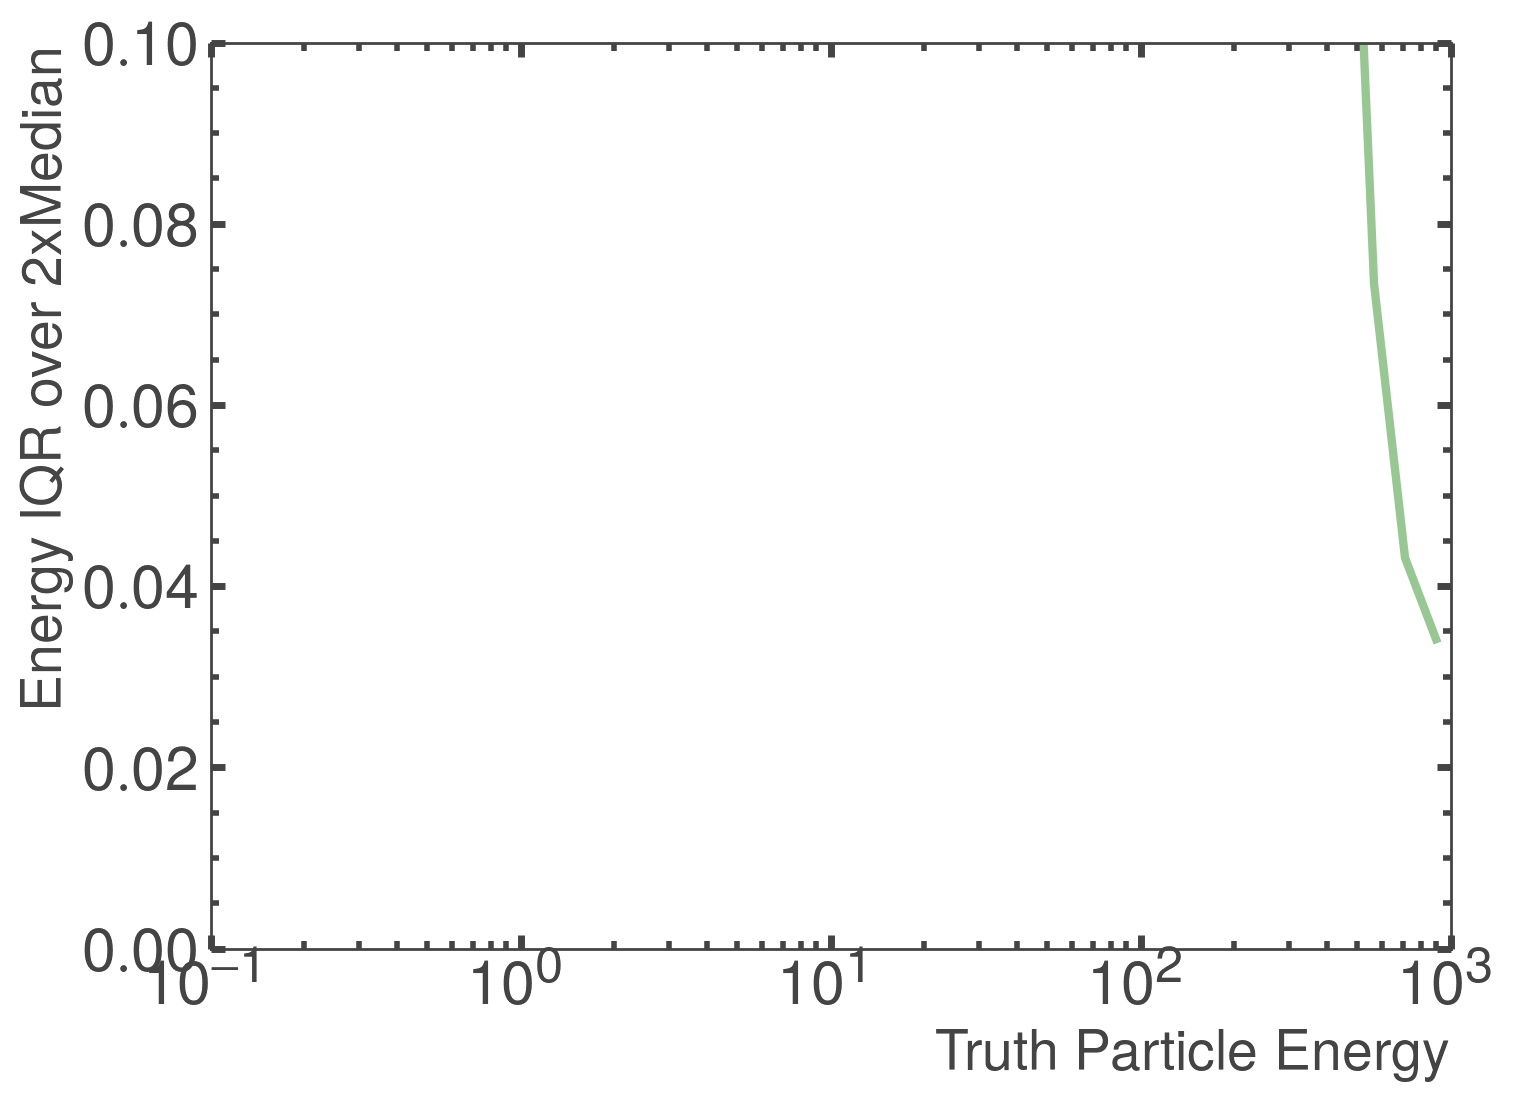

<Figure size 1600x1200 with 0 Axes>

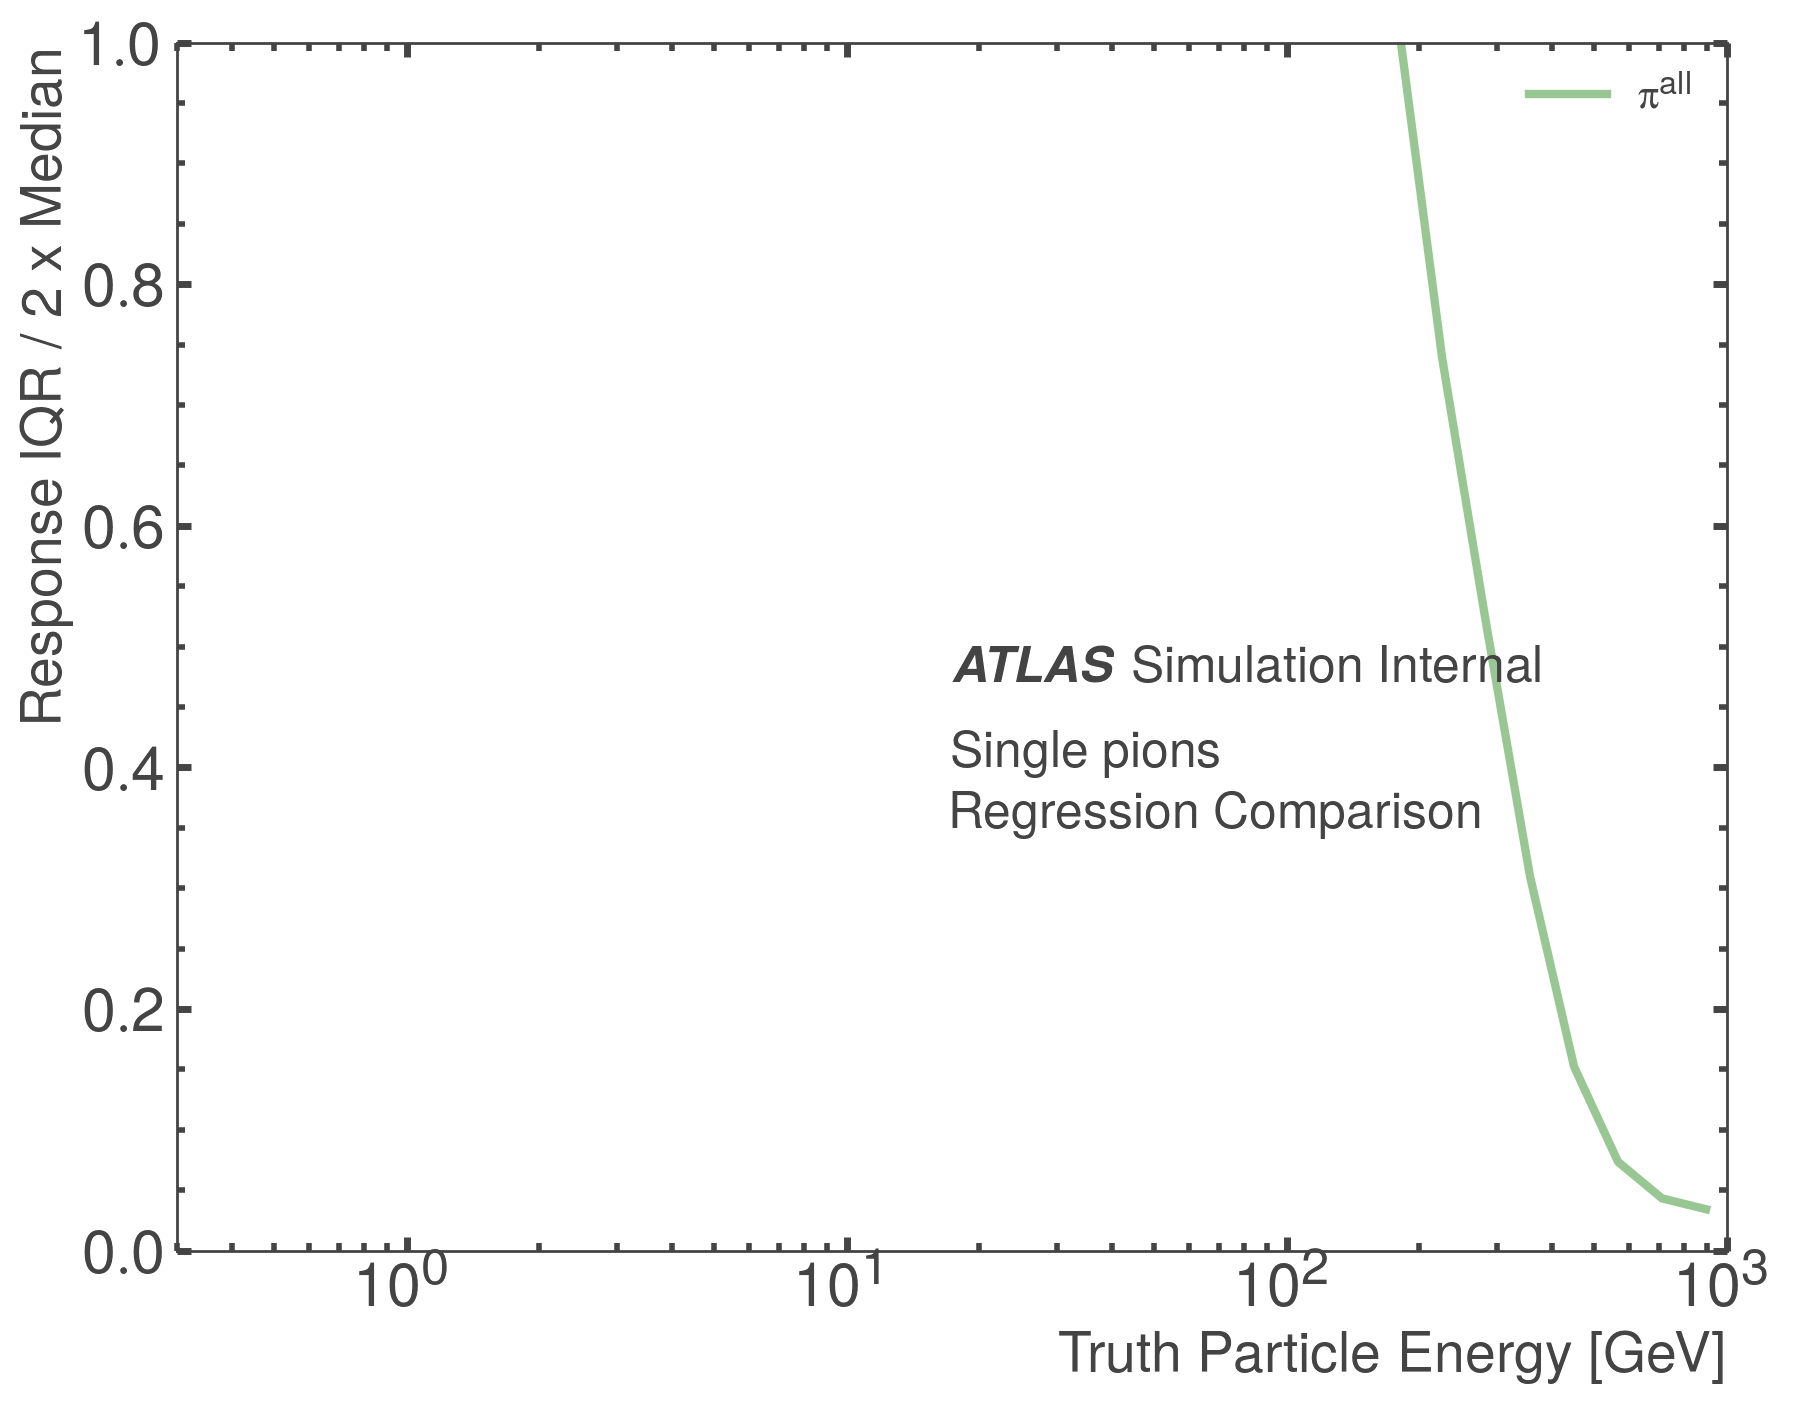

In [34]:
# truth_particle_e = df_em_lcw.truthPartE.explode().astype(np.float32)
# calib_energy = df_em_lcw.cluster_calib_e_0
# energy = df_em_lcw.cluster_e_0
# lcw = df_em_lcw.lcw_0
# sum_energy = df_em_lcw.sum_cluster_e
# sum_lcw = df_em_lcw.sum_lcw

# truth_particle_e = df_em_lcw.truth_particle_e
calib_energy = df_em_lcw.cluster_calib_e
energy = df_em_lcw.energy
lcw = df_em_lcw.energy*df_em_lcw.cluster_had_weight

### EM Calib 
c_map = sns.color_palette("viridis")

pion_list = [
#     '$\pi^{all}$', 
#              '$\pi^{0}$', 
             '$\pi^{\pm}$'
]
sym_list = [
#     '', 
#             '0', 
            '+-'
           ]
blues = matplotlib.cm.viridis(np.linspace(0,1,20))
oranges = matplotlib.cm.viridis(np.linspace(0,1,20))

response_median = []

print('\nPlotting {}'.format(pion_list[0]))
y_true = calib_energy #truth_particle_e
y_pred = energy # EM calib
y_ratio = y_pred/y_true

xcenter, medRegCNN = make_response_plot(y_true, y_pred, y_pred/y_true, pion_list[0], 
                                        f_name='pub_note_results/regress_em_all.png'
                                       )
response_median.append(medRegCNN)

if "targets_class" in df_em_lcw.keys():
    print('\nPlotting {}'.format(pion_list[1]))
    y_true = df_em_lcw[df_em_lcw.targets_class == 0].truth_particle_e
    y_pred = df_em_lcw[df_em_lcw.targets_class == 0].energy # EM calib
    xcenter, medRegCNN = make_response_plot(y_true, y_pred, y_pred/y_true, pion_list[1], 
                                            f_name='pub_note_results/regress_em_pi0.png'
                                           )
    response_median.append(medRegCNN)

    print('\nPlotting {}'.format(pion_list[2]))
    y_true = df_em_lcw[df_em_lcw.targets_class == 1].truth_particle_e
    y_pred = df_em_lcw[df_em_lcw.targets_class == 1].energy # EM calib
    xcenter, medRegCNN = make_response_plot(y_true, y_pred, y_pred/y_true, pion_list[2], 
                                            f_name='pub_note_results/regress_em_pion.png'
                                           )
    response_median.append(medRegCNN)


np.savez('pub_note_results/response_medians_em.npz', response_median=response_median, xcenter=xcenter)

### IQR Plots
iqr = []
print('\nPlotting {}'.format(pion_list[0]))
xcenter, iqr_curr= ru.resolutionPlot(y_true, y_ratio, statistic='iqrOverMed')
iqr.append(iqr_curr)

# if "targets_class" in df_em_lcw.keys():
#     print('\nPlotting {}'.format(pion_list[1]))
#     y_true = df_em_lcw[df_em_lcw.targets_class == 0].truth_particle_e
#     y_pred = df_em_lcw[df_em_lcw.targets_class == 0].energy # EM calib
#     y_ratio = y_pred/y_true
#     xcenter, iqr_curr= ru.resolutionPlot(y_true, y_ratio, statistic='iqrOverMed')
#     iqr.append(iqr_curr)

#     print('\nPlotting {}'.format(pion_list[2]))
#     y_true = df_em_lcw[df_em_lcw.targets_class == 1].truth_particle_e
#     y_pred = df_em_lcw[df_em_lcw.targets_class == 1].energy # EM calib
#     y_ratio = y_pred/y_true
#     xcenter, iqr_curr= ru.resolutionPlot(y_true, y_ratio, statistic='iqrOverMed')
#     iqr.append(iqr_curr)
    
pu.lineOverlay(xcenter=xcenter, lines = iqr[:],  # [iqrOverMedpi0, iqrOverMedpiplus, iqrOverMedpiminus],
            labels = [
                    r'$\pi^{all}$', 
                    r'$\pi^{0}$', 
                r'$\pi^{\pm}$'],
            xlabel = 'Truth Particle Energy [GeV]', ylabel = 'Response IQR / 2 x Median',
            y_max = 1,  # default = 0.5
               x_min = .3,
            linestyles = [
                    'solid', 
                    'solid', 
                'solid'
            ],  
            atlas_x = 0.5, atlas_y = 0.5, simulation = True,
            textlist = [{'x': 0.5, 'y': 0.4, 'text': 'Single $pions$'},
                        {'x': 0.5, 'y': 0.35,  'text': 'Regression Comparison'}],
              figfile='pub_note_results/regress_em_iqr.png')
np.savez('pub_note_results/iqr_em.npz', iqr=iqr, xcenter=xcenter)


### LCW Calib 
response_median = []

print('\nPlotting {}'.format(pion_list[0]))
y_true = calib_energy #truth_particle_e
y_pred = lcw
y_ratio = y_pred/y_true

xcenter, medRegCNN = make_response_plot(y_true, y_pred, y_pred/y_true, pion_list[0], 
                                        f_name='pub_note_results/regress_lcw_all.png'
                                       )
response_median.append(medRegCNN)

# if "targets_class" in df_em_lcw.keys():
#     print('\nPlotting {}'.format(pion_list[1]))
#     y_true = df_em_lcw[df_em_lcw.targets_class == 0].truth_particle_e
#     y_pred = df_em_lcw[df_em_lcw.targets_class == 0].energy*df_em_lcw[df_em_lcw.targets_class == 0].cluster_had_weight # LCW calib
#     xcenter, medRegCNN = make_response_plot(y_true, y_pred, y_pred/y_true, pion_list[1], 
#                                             f_name='pub_note_results/regress_lcw_pi0.png'
#                                            )
#     response_median.append(medRegCNN)
#     print('\nPlotting {}'.format(pion_list[2]))
#     y_true = df_em_lcw[df_em_lcw.targets_class == 1].truth_particle_e
#     y_pred = df_em_lcw[df_em_lcw.targets_class == 1].energy*df_em_lcw[df_em_lcw.targets_class == 1].cluster_had_weight # LCW calib
#     xcenter, medRegCNN = make_response_plot(y_true, y_pred, y_pred/y_true, pion_list[2], 
#                                             f_name='pub_note_results/regress_lcw_pion.png'
#                                            )
#     response_median.append(medRegCNN)

np.savez('./pub_note_results/response_medians_lcw.npz', response_median=response_median, xcenter=xcenter)


### IQR Plots
iqr = []
print('\nPlotting {}'.format(pion_list[0]))
xcenter, iqr_curr= ru.resolutionPlot(y_true, y_ratio, statistic='iqrOverMed')
iqr.append(iqr_curr)

# if "targets_class" in df_em_lcw.keys():
#     print('\nPlotting {}'.format(pion_list[1]))
#     y_true = df_em_lcw[df_em_lcw.targets_class == 0].truth_particle_e
#     y_pred = df_em_lcw[df_em_lcw.targets_class == 0].energy*df_em_lcw[df_em_lcw.targets_class == 0].cluster_had_weight # LCW calib
#     y_ratio = y_pred/y_true
#     xcenter, iqr_curr= ru.resolutionPlot(y_true, y_ratio, statistic='iqrOverMed')
#     iqr.append(iqr_curr)

#     print('\nPlotting {}'.format(pion_list[2]))
#     y_true = df_em_lcw[df_em_lcw.targets_class == 1].truth_particle_e
#     y_pred = df_em_lcw[df_em_lcw.targets_class == 1].energy*df_em_lcw[df_em_lcw.targets_class == 1].cluster_had_weight # LCW calib
#     y_ratio = y_pred/y_true
#     xcenter, iqr_curr= ru.resolutionPlot(y_true, y_ratio, statistic='iqrOverMed')
#     iqr.append(iqr_curr)

pu.lineOverlay(xcenter=xcenter, lines = iqr[:], 
            labels = [
                    r'$\pi^{all}$', 
                    r'$\pi^{0}$', 
                r'$\pi^{\pm}$'],
            xlabel = 'Truth Particle Energy [GeV]', ylabel = 'Response IQR / 2 x Median',
            y_max = 1,  # default = 0.5
               x_min = .3,
            linestyles = [
                    'solid', 
                    'solid', 
                'solid'
            ],  
            atlas_x = 0.5, atlas_y = 0.5, simulation = True,
            textlist = [{'x': 0.5, 'y': 0.4, 'text': 'Single $pions$'},
                        {'x': 0.5, 'y': 0.35,  'text': 'Regression Comparison'}],
              figfile='pub_note_results/regress_lcw_iqr.png')
np.savez('pub_note_results/iqr_lcw.npz', iqr=iqr, xcenter=xcenter)

#### Cluster-only

In [ ]:
### PFN Cluster-only 
make_regression_plots(df_russell_clusteronly, label="pfn_clusteronly", charged_pions_only=True, data_dir='./pub_note_results')

In [ ]:
### GNN Cluster-only
## Use this file: pred_file = 'pub_note_results/validation_data_predictions_multiJobTraining.npz'
make_regression_plots(df, label="gnn", data_dir='./pub_note_results')

#### Cluster-only median overlay:

In [ ]:
### All pions 
median_gnn = np.load('pub_note_results/response_medians_gnn_clusteronly.npz')
median_em =  np.load('pub_note_results/response_medians_em.npz')
median_lcw =  np.load('pub_note_results/response_medians_lcw.npz')

from scipy.signal import savgol_filter # for smoothing the PFN results due to stats difference

xcenter = median_gnn['xcenter']
median_2 = [
    median_em['response_median'][0,:],
    median_lcw['response_median'][0,:],
    median_gnn['response_median'][0,:],
      ]
labels=['EM', 'LCW', 'GNN',]

### Response medians 
pu.lineOverlay(xcenter=xcenter, lines=median_2,  
            labels=labels,
            xlabel = 'True Cluster Energy [GeV]', ylabel = 'Response Median',
            figfile = 'pub_note_results/regress_response_medians_all.png',
            y_max=1.2, y_min=.95, 
               x_min = .3, 
               colorgrouping=0,
            extra_lines= [[[0, 10e3], [1, 1]]],
            linestyles = ['dashed', 'dashed', 'solid', 'solid', 'solid', 'solid'],
            atlas_x = 0.45, atlas_y = 0.7, simulation = True,
            textlist = [{'x': 0.45, 'y': 0.6, 'text': 'Single $\pi^0/\pi^{\pm}$ MC Regression'},
                        {'x': 0.45, 'y': 0.55,  'text': 'Topo-clusters, |$\eta$| < 3'},])

In [ ]:
### Neutral pions 
median_gnn = np.load('pub_note_results/response_medians_gnn_clusteronly.npz')
median_em =  np.load('pub_note_results/response_medians_em.npz')
median_lcw =  np.load('pub_note_results/response_medians_lcw.npz')

from scipy.signal import savgol_filter # for smoothing the PFN results due to stats difference

xcenter = median_gnn['xcenter']
median_2 = [
    median_em['response_median'][1,:],
    median_lcw['response_median'][1,:],
    median_gnn['response_median'][1,:],
      ]
labels=['EM', 'LCW', 'GNN',]

### Response medians 
pu.lineOverlay(xcenter=xcenter, lines=median_2,  
            labels=labels,
            xlabel = 'True Cluster Energy [GeV]', ylabel = 'Response Median',
            figfile = 'pub_note_results/regress_response_medians_pi0.png',
            y_max=1.2, y_min=.95, 
               x_min = .3, 
               colorgrouping=0,
            extra_lines= [[[0, 10e3], [1, 1]]],
            linestyles = ['dashed', 'dashed', 'solid', 'solid', 'solid', 'solid'],
            atlas_x = 0.45, atlas_y = 0.7, simulation = True,
            textlist = [{'x': 0.45, 'y': 0.6, 'text': 'Single $\pi^0$ MC Regression'},
                        {'x': 0.45, 'y': 0.55,  'text': 'Topo-clusters, |$\eta$| < 3'},
                       ])

In [ ]:
### Charged pions 
median_gnn = np.load('pub_note_results/response_medians_gnn_clusteronly.npz')
median_pfn = np.load('pub_note_results/response_medians_pfn_clusteronly.npz')
median_em =  np.load('pub_note_results/response_medians_em.npz')
median_lcw =  np.load('pub_note_results/response_medians_lcw.npz')

from scipy.signal import savgol_filter # for smoothing the PFN results due to stats difference

xcenter = median_gnn['xcenter']
median_2 = [
    median_em['response_median'][2,:],
    median_lcw['response_median'][2,:],
    median_gnn['response_median'][2,:],
#     median_pfn['response_median'][0,:],
    savgol_filter(median_pfn['response_median'][0,:], 11, 1), # window size = 11, polynomial order 1
      ]
labels=['EM', 'LCW', 'GNN', 'DeepSets/PFN',]

### Response medians 
pu.lineOverlay(xcenter=xcenter, lines=median_2,  
            labels=labels,
            xlabel = 'True Cluster Energy [GeV]', ylabel = 'Response Median',
            figfile = 'pub_note_results/regress_response_medians_pipm.png',
            y_max=1.2, y_min=.9, 
               x_min = .3, 
               colorgrouping=0,
            extra_lines= [[[0, 10e3], [1, 1]]],
            linestyles = ['dashed', 'dashed', 'solid', '-.', 'solid', 'solid'],
            atlas_x = 0.45, atlas_y = 0.6, simulation = True,
            textlist = [{'x': 0.45, 'y': 0.5, 'text': 'Single $\pi^\pm$ MC Regression'},
                        {'x': 0.45, 'y': 0.45,  'text': 'Topo-clusters, |$\eta$| < 3'},
                       ])

#### Cluster-only IQR:

In [ ]:
### All pions 
iqr_gnn = np.load('pub_note_results/iqr_gnn_clusteronly.npz')
iqr_pfn = np.load('pub_note_results/iqr_pfn_clusteronly.npz')
iqr_em =  np.load('pub_note_results/iqr_em.npz')
iqr_lcw =  np.load('pub_note_results/iqr_lcw.npz')

from scipy.signal import savgol_filter # for smoothing the PFN results due to stats difference

xcenter = iqr_gnn['xcenter']

iqr_2 = [
    iqr_em['iqr'][0,:],
    iqr_lcw['iqr'][0,:],
    iqr_gnn['iqr'][0,:],
      ]

labels=['EM', 'LCW', 'GNN', ]

pu.lineOverlay(xcenter=xcenter, lines = iqr_2,  
            labels = labels,
            xlabel = 'True Cluster Energy [GeV]', ylabel = 'Response IQR / (2 x Median)',
            y_max = 0.5,  
               x_min = .3,
            linestyles = ['dashed','dashed','solid','solid','solid','solid'],  
            atlas_x = 0.45, atlas_y = 0.7, simulation = True,
            textlist = [{'x': 0.45, 'y': 0.6, 'text': 'Single $\pi^0/\pi^{\pm}$ MC Regression'},
                        {'x': 0.45, 'y': 0.55,  'text': 'Topo-clusters'},
                        {'x': 0.45, 'y': 0.5, 'text': '|$\eta$| < 3'}],
#               figfile='pub_note_results/regress_cluster_only_iqr_all.png'
              )

In [ ]:
### Neutral pions 
iqr_gnn = np.load('pub_note_results/iqr_gnn_clusteronly.npz')
iqr_pfn = np.load('pub_note_results/iqr_pfn_clusteronly.npz')
iqr_em =  np.load('pub_note_results/iqr_em.npz')
iqr_lcw =  np.load('pub_note_results/iqr_lcw.npz')

from scipy.signal import savgol_filter # for smoothing the PFN results due to stats difference

xcenter = iqr_gnn['xcenter']

iqr_2 = [
    iqr_em['iqr'][1,:],
    iqr_lcw['iqr'][1,:],
    iqr_gnn['iqr'][1,:],
      ]

labels=['EM', 'LCW', 'GNN', ]

pu.lineOverlay(xcenter=xcenter, lines = iqr_2,  
            labels = labels,
            xlabel = 'True Cluster Energy [GeV]', ylabel = 'Response IQR / (2 x Median)',
            y_max = 0.5,  
               x_min = .3,
            linestyles = ['dashed','dashed','solid','solid','solid','solid'],  
            atlas_x = 0.4, atlas_y = 0.6, simulation = True,
            textlist = [{'x': 0.4, 'y': 0.5, 'text': 'Single $\pi^{0}$ MC Regression'},
                        {'x': 0.4, 'y': 0.45,  'text': 'Topo-clusters'},
                       {'x': 0.4, 'y': 0.4, 'text': '|$\eta$| < 3'}],
              figfile='pub_note_results/regress_cluster_only_iqr_pi0.png'
              )

In [ ]:
### Charged pions 
iqr_gnn = np.load('pub_note_results/iqr_gnn_clusteronly.npz')
iqr_pfn = np.load('pub_note_results/iqr_pfn_clusteronly.npz')
iqr_em =  np.load('pub_note_results/iqr_em.npz')
iqr_lcw =  np.load('pub_note_results/iqr_lcw.npz')

from scipy.signal import savgol_filter # for smoothing the PFN results due to stats difference

xcenter = iqr_gnn['xcenter']

### 3rd row is the charged pion for most of these
iqr_2 = [
    iqr_em['iqr'][2,:],
    iqr_lcw['iqr'][2,:],
    iqr_gnn['iqr'][2,:],
#     iqr_pfn['iqr'][0,:],
    savgol_filter(iqr_pfn['iqr'][0,:], 11, 1), # window size = 11, polynomial order 1
      ]

labels=['EM', 'LCW', 'GNN', 'DeepSets/PFN', ]

pu.lineOverlay(xcenter=xcenter, lines = iqr_2,  
            labels = labels,
            xlabel = 'True Cluster Energy [GeV]', ylabel = 'Response IQR / (2 x Median)',
            y_max = 0.5,  
               x_min = .3,
            linestyles = ['dashed','dashed','solid','-.','solid','solid'],  
            atlas_x = 0.45, atlas_y = 0.6, simulation = True,
            textlist = [{'x': 0.45, 'y': 0.5, 'text': 'Single $\pi^{\pm}$ MC Regression'},
                        {'x': 0.45, 'y': 0.45,  'text': 'Topo-clusters'},
                        {'x': 0.45, 'y': 0.4, 'text': '|$\eta$| < 3'}],
              figfile='pub_note_results/regress_cluster_only_iqr_pion.pdf'
              )

# New plots

#### Clusters + tracks

In [ ]:
make_regression_plots(df_russell_new, label="pfn", data_dir='./pub_note_results')

In [ ]:
# make_regression_plots(df_transformer, label="transformer", data_dir='./pub_note_results')

In [ ]:
# make_regression_plots(df, label="gnn", data_dir='./pub_note_results')

#### Clusters + tracks median overlay

In [ ]:
# median_gnn = np.load('pub_note_results/response_medians_gnn.npz')
# median_tnet = np.load('pub_note_results/response_medians_russell_0324.npz')
median_em =  np.load('pub_note_results/response_medians_em.npz')
median_lcw =  np.load('pub_note_results/response_medians_lcw.npz')
median_pfn = np.load('pub_note_results/response_medians_pfn.npz')
median_transformer = np.load('pub_note_results/response_medians_transformer.npz')
median_dnn = np.load('pub_note_results/response_medians_dnn.npz')
median_gnn = np.load(data_dir+'/response_medians_gnn.npz')
# median_gnn = np.load('pub_note_results/response_medians_gnn_piyush.npz') 

# Tracks
# y_true = df.truth_particle_pt*np.cosh(df.track_eta)
# y_pred = df.track_pt*np.cosh(df.track_eta)
# xcenter, median_track = make_response_plot(y_true, y_pred, y_pred/y_true, '$\pi^{\pm}$', )

xcenter = median_em['xcenter']

from scipy.signal import savgol_filter # for smoothing the PFN results due to stats difference


median_2 = [
#     median_em['response_median'][0,:],
#     median_lcw['response_median'][0,:],
    median_transformer['response_median'][0,:],
    median_pfn['response_median'][0,:], # window size = 11, polynomial order 1
#     median_gnn['response_median'][0,:],
#     median_dnn['response_median'],
    median_gnn['response_median'][0,:],
#     median_track,
      ]

labels=[
#     'EM', 'LCW', 
        'Transformer', 'DeepSets/PFN', 
#         'DNN',
        'GNN', 
#         'Mariel GNN',
#         'Track', 
       ]

### Response medians 
pu.lineOverlay(xcenter=xcenter, lines=median_2,  
            labels=labels,
            xlabel = 'Truth Particle Energy [GeV]', ylabel = 'Response Median',
#             figfile = 'pub_note_results/regress_response_medians_all.png',
            y_max=1.2, y_min=.9, 
               x_min = .3, 
               colorgrouping=0,
            extra_lines= [[[0, 10e3], [1, 1]]],
            linestyles = ['dashed', 'dashed', 'solid', 'solid', 'solid', 'solid', 'solid',
                         ], # , 'dashed',],
            atlas_x = 0.05, atlas_y = 0.85, simulation = True,
            textlist = [{'x': 0.05, 'y': 0.775, 'text': 'Single $pions$'},
                        {'x': 0.05, 'y': 0.725,  'text': 'Regression Comparison'}])

#### Cluster + track IQR overlay

<Figure size 1600x1200 with 0 Axes>

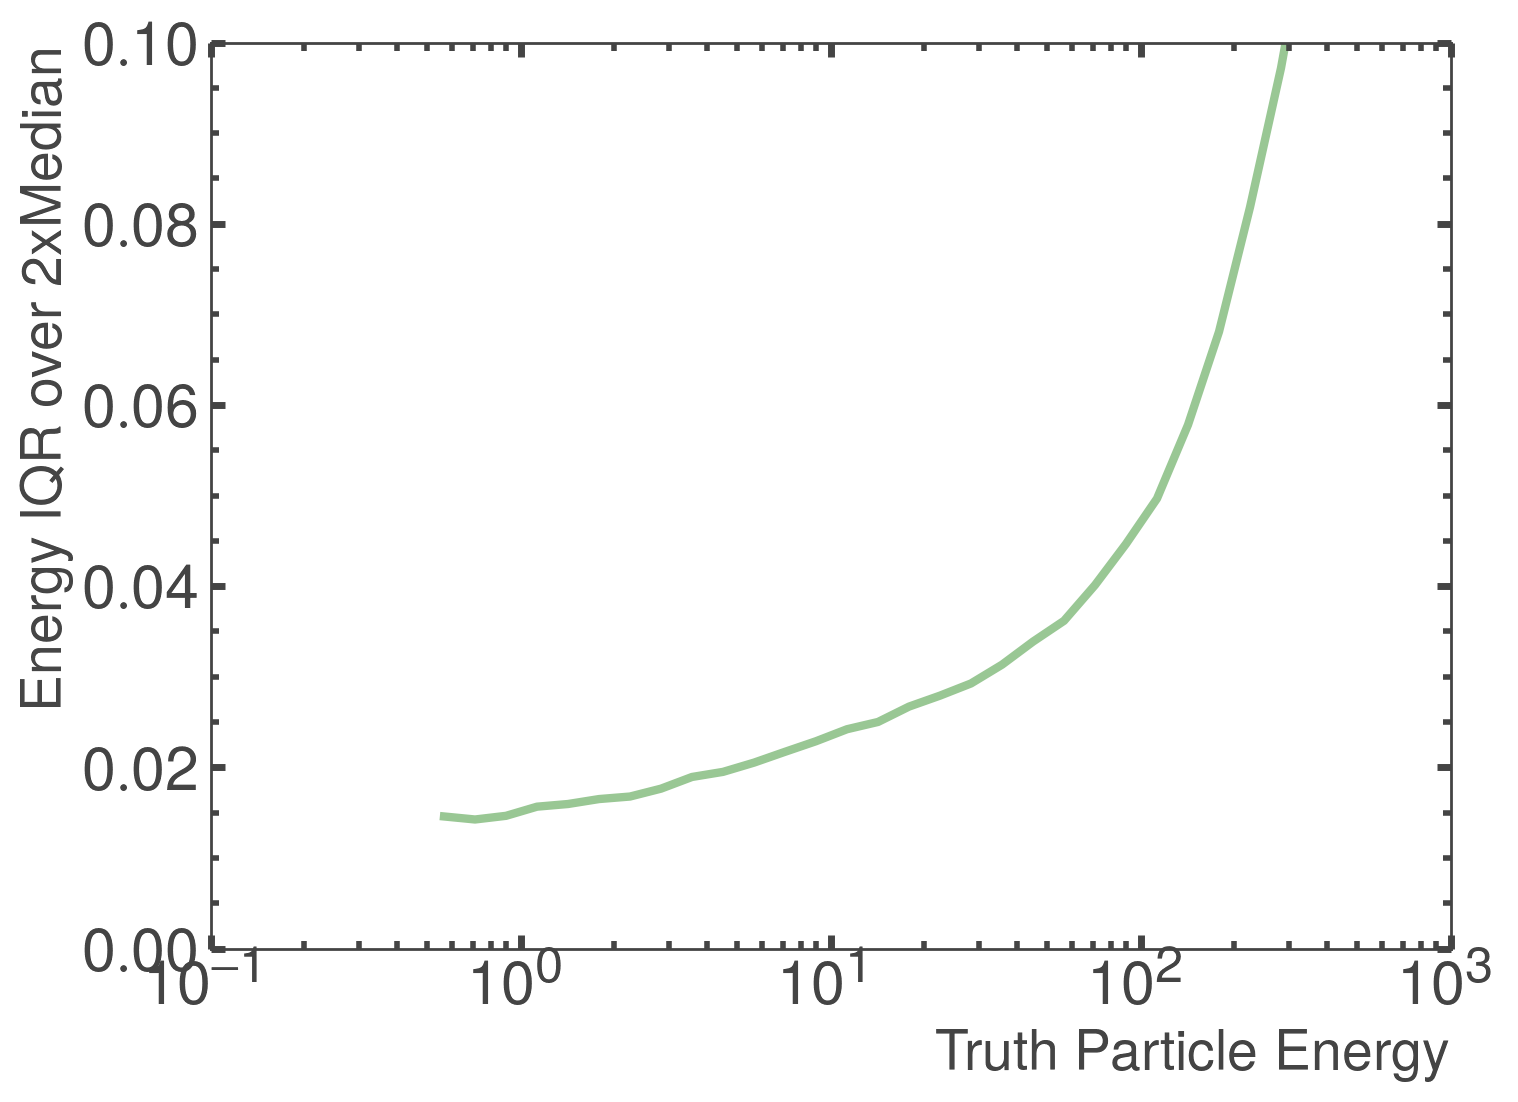

<Figure size 1600x1200 with 0 Axes>

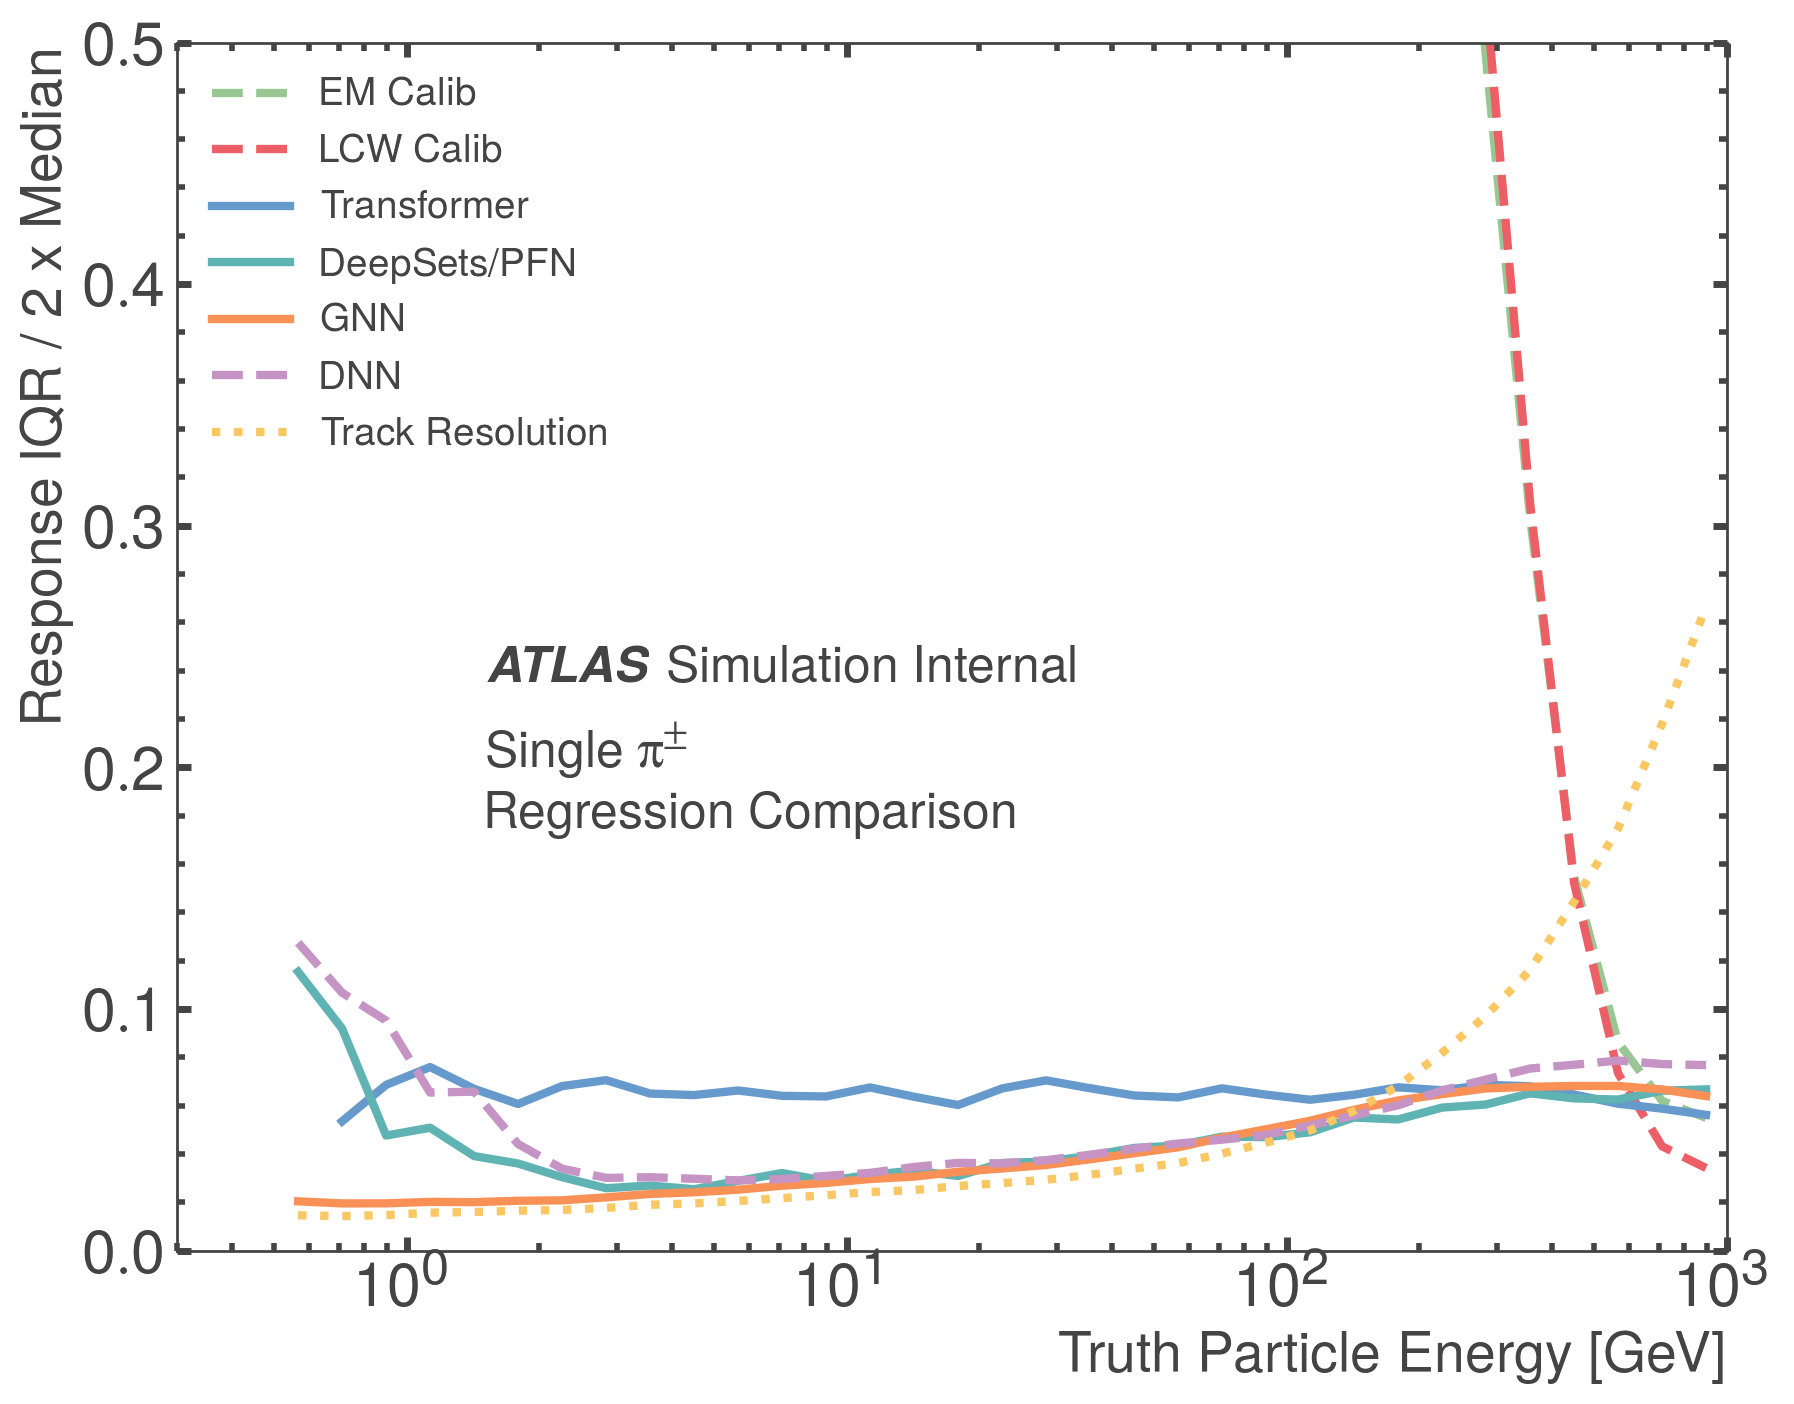

In [19]:
iqr_gnn = np.load(data_dir+'/iqr_gnn.npz')# iqr_gnn = np.load('pub_note_results/iqr_gnn.npz')
iqr_transformer = np.load('pub_note_results/iqr_transformer.npz')
iqr_pfn = np.load('pub_note_results/iqr_pfn.npz')
iqr_em =  np.load('pub_note_results/iqr_em.npz')
iqr_lcw =  np.load('pub_note_results/iqr_lcw.npz')
iqr_dnn = np.load('pub_note_results/iqr_dnn.npz')

xcenter, iqr_track = ru.resolutionPlot(df.truth_particle_e, 
                                       (10**df.track_pt)*np.cosh(df.track_eta)/df.truth_particle_e,
                                       statistic='iqrOverMed')

xcenter = iqr_gnn['xcenter']
iqr_2 = [
    iqr_em['iqr'][0,:], # use 2 for default df_em_lcw files
    iqr_lcw['iqr'][0,:], # use 2 for default df_em_lcw files
    iqr_transformer['iqr'][0,:],
    iqr_pfn['iqr'][0,:],
    iqr_gnn['iqr'][0,:],
    iqr_dnn['iqr'],
    iqr_track,
      ]

labels=[
    'EM Calib', 
        'LCW Calib', 
        'Transformer', 
        'DeepSets/PFN', 
        'GNN', 
        'DNN',
        'Track Resolution',
       ]

pu.lineOverlay(xcenter=xcenter, lines = iqr_2, 
            labels = labels,
            xlabel = 'Truth Particle Energy [GeV]', ylabel = 'Response IQR / 2 x Median',
            y_max = 0.5,  # default = 0.5
               x_min = .3,
            linestyles = [
                'dashed',
                          'dashed',
                          'solid','solid','solid',
#                 'solid',
#                 'solid','solid',
                'dashed','dotted'
            ],  
            atlas_x = 0.2, atlas_y = 0.5, simulation = True,
            textlist = [{'x': 0.2, 'y': 0.4, 'text': 'Single $\pi^{\pm}$'},
                        {'x': 0.2, 'y': 0.35,  'text': 'Regression Comparison'}],
#               figfile='pub_note_results/regress_all_iqr.png'
              )